# Object Detection

## Task 2: Apply and Analyze Object Detection Models

by Dechathon Niamsa-ard [st126235]


**Goal:** Compare a **two-stage** detector and a **single-stage** detector.

**Recommended Models:**

- Two-stage: [Faster R-CNN (TorchVision)]
- Single-stage: YOLO v11

**Dataset Options:**

- [COCO 2017 (Mini subset)] — 128 annotated images
- [Pascal VOC 2007]

**Instructions:**

1. Run both detectors on the same dataset.
2. Measure:
- Detection accuracy (mAP or precision-recall curves)
- Inference speed (FPS)
- Model size and memory usage
3. Visualize 5–10 images with predicted bounding boxes.
4. Optionally, test reduced input resolutions or lightweight model variants.

**Deliverables:**

- Notebook with detection and evaluation pipeline
- Quantitative comparison table
- Example detection results
- Short discussion on performance trade-offs

---

##  Import necessary libraries

In [1]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import ultralytics
from ultralytics import YOLO
import torchvision.transforms as transforms
import torchvision.models.detection as detection
import cv2
from PIL import Image, ImageDraw, ImageFont
import time
import os
import pandas as pd

## Setup Config

## Make sure the torch is using GPU

In [2]:
!nvidia-smi

Fri Oct 31 21:24:16 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 580.88                 Driver Version: 580.88         CUDA Version: 13.0     |
+-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 5060 Ti   WDDM  |   00000000:02:00.0  On |                  N/A |
|  0%   33C    P5              8W /  180W |     408MiB /  16311MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [3]:
# Check if GPU is available and set device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

Using device: cuda


## Download Dataset: COCO 2017 (Mini subset)

In [4]:
# Download COCO 2017 (mini subset) dataset via kagglehub: https://www.kaggle.com/datasets/ultralytics/coco128
import kagglehub
import shutil

# Download the dataset to the default cache.
# The function returns the path to the downloaded files in the cache.
print("Downloading dataset via kagglehub")
download_path = kagglehub.dataset_download("ultralytics/coco128")
print(f"Dataset downloaded to cache: {download_path}")

# Move files to the current working directory
# Get the current directory path for confirmation message.
current_dir = os.getcwd()
print(f"\nMoving dataset files to the current directory: {current_dir}")

# List all files/folders in the downloaded path.
for item_name in os.listdir(download_path):
    source_item = os.path.join(download_path, item_name)
    destination_item = os.path.join(current_dir, item_name)
    
    # Use shutil.move to transfer the item.
    # This will overwrite existing files/folders with the same name.
    shutil.move(source_item, destination_item)
    print(f" - Moved '{item_name}'")

c:\Users\USER\Documents\Dechathon_N\AIT\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Dataset downloaded to cache: C:\Users\USER\.cache\kagglehub\datasets\ultralytics\coco128\versions\3

Moving dataset files to the current directory: c:\Users\USER\Documents\Dechathon_N\AIT\Computer Vision\AIT-Computer-Vision-Assignment2


In [5]:
# Create a list of class names ordered by their class IDs
COCO_CLASSES = ['person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 
                'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 
                'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 
                'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 
                'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch', 'potted plant', 
                'bed', 'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 
                'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush']
print(f"COCO class names: {COCO_CLASSES}")

COCO class names: ['person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush']


## Prepare Models

### Training Configuration

**Important Notes:**
- Both models will be trained for **20 epochs** for fair comparison
- Transfer learning approach: Starting with pretrained weights and fine-tuning
- Faster R-CNN: Batch size 2, SGD optimizer (lr=0.005)
- YOLOv8: Batch size 8, built-in optimizer configuration
- Dataset: COCO128 (128 images) split for training

In [6]:
# Prepare the dataset 
from torch.utils.data import Dataset, DataLoader
import json

# Path to dataset
dataset_path = 'coco128'
images_path = os.path.join(dataset_path, 'images', 'train2017')
labels_path = os.path.join(dataset_path, 'labels', 'train2017')

# Get all image files
image_files = sorted([f for f in os.listdir(images_path) if f.endswith(('.jpg', '.png', '.jpeg'))])
print(f"Found {len(image_files)} images in dataset")

# Create a custom dataset class for evaluation
class COCO128Dataset(Dataset):
    def __init__(self, images_path, labels_path, transform=None):
        self.images_path = images_path
        self.labels_path = labels_path
        self.transform = transform
        self.image_files = sorted([f for f in os.listdir(images_path) if f.endswith(('.jpg', '.png', '.jpeg'))])
    
    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, idx):
        img_name = self.image_files[idx]
        img_path = os.path.join(self.images_path, img_name)
        
        # Load image
        image = Image.open(img_path).convert('RGB')
        
        # Load labels (YOLO format: class x_center y_center width height)
        label_name = img_name.replace('.jpg', '.txt').replace('.png', '.txt')
        label_path = os.path.join(self.labels_path, label_name)
        
        boxes = []
        labels = []
        
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                for line in f.readlines():
                    parts = line.strip().split()
                    if len(parts) >= 5:
                        class_id = int(parts[0])
                        x_center, y_center, width, height = map(float, parts[1:5])
                        
                        # Convert YOLO format to absolute coordinates
                        img_width, img_height = image.size
                        x1 = (x_center - width / 2) * img_width
                        y1 = (y_center - height / 2) * img_height
                        x2 = (x_center + width / 2) * img_width
                        y2 = (y_center + height / 2) * img_height
                        
                        boxes.append([x1, y1, x2, y2])
                        labels.append(class_id)
        
        return {
            'image': image,
            'image_path': img_path,
            'boxes': torch.tensor(boxes, dtype=torch.float32) if boxes else torch.zeros((0, 4)),
            'labels': torch.tensor(labels, dtype=torch.int64) if labels else torch.zeros((0,), dtype=torch.int64)
        }

# Create dataset instance
dataset = COCO128Dataset(images_path, labels_path)
print(f"Dataset prepared with {len(dataset)} images")

# Create train/val/test split (70/15/15)
from sklearn.model_selection import train_test_split
import random

# Set random seed for reproducibility
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

# Get all indices
all_indices = list(range(len(dataset)))

# Split: 70% train, 15% val, 15% test
train_indices, temp_indices = train_test_split(all_indices, train_size=0.7, random_state=42)
val_indices, test_indices = train_test_split(temp_indices, train_size=0.5, random_state=42)

print(f"\nDataset Split:")
print(f"  Training: {len(train_indices)} images ({len(train_indices)/len(dataset)*100:.1f}%)")
print(f"  Validation: {len(val_indices)} images ({len(val_indices)/len(dataset)*100:.1f}%)")
print(f"  Test: {len(test_indices)} images ({len(test_indices)/len(dataset)*100:.1f}%)")

# Create subset datasets
from torch.utils.data import Subset

train_dataset = Subset(dataset, train_indices)
val_dataset = Subset(dataset, val_indices)
test_dataset = Subset(dataset, test_indices)

print(f"\nDataset objects created for train/val/test splits")

Found 128 images in dataset
Dataset prepared with 128 images

Dataset Split:
  Training: 89 images (69.5%)
  Validation: 19 images (14.8%)
  Test: 20 images (15.6%)

Dataset objects created for train/val/test splits


### 1. Two-stage: Faster R-CNN

We'll use transfer learning - starting with pretrained weights and fine-tuning on COCO128.

In [7]:
# Prepare dataset for Faster R-CNN training
from torch.utils.data import DataLoader
import torch.optim as optim

class FasterRCNNDataset(Dataset):
    """Dataset class compatible with Faster R-CNN training"""
    def __init__(self, images_path, labels_path, transforms=None):
        self.images_path = images_path
        self.labels_path = labels_path
        self.transforms = transforms
        self.image_files = sorted([f for f in os.listdir(images_path) if f.endswith(('.jpg', '.png', '.jpeg'))])
    
    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, idx):
        img_name = self.image_files[idx]
        img_path = os.path.join(self.images_path, img_name)
        
        # Load image
        image = Image.open(img_path).convert('RGB')
        image_tensor = transforms.ToTensor()(image)
        
        # Load labels
        label_name = img_name.replace('.jpg', '.txt').replace('.png', '.txt')
        label_path = os.path.join(self.labels_path, label_name)
        
        boxes = []
        labels = []
        
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                for line in f.readlines():
                    parts = line.strip().split()
                    if len(parts) >= 5:
                        class_id = int(parts[0]) + 1  # Faster R-CNN uses 1-indexed (0 is background)
                        x_center, y_center, width, height = map(float, parts[1:5])
                        
                        # Convert to absolute coordinates
                        img_width, img_height = image.size
                        x1 = (x_center - width / 2) * img_width
                        y1 = (y_center - height / 2) * img_height
                        x2 = (x_center + width / 2) * img_width
                        y2 = (y_center + height / 2) * img_height
                        
                        boxes.append([x1, y1, x2, y2])
                        labels.append(class_id)
        
        # Convert to tensors
        if len(boxes) == 0:
            boxes = torch.zeros((0, 4), dtype=torch.float32)
            labels = torch.zeros((0,), dtype=torch.int64)
        else:
            boxes = torch.as_tensor(boxes, dtype=torch.float32)
            labels = torch.as_tensor(labels, dtype=torch.int64)
        
        target = {
            'boxes': boxes,
            'labels': labels,
            'image_id': torch.tensor([idx])
        }
        
        return image_tensor, target

# Create training and validation datasets for Faster R-CNN
train_dataset_rcnn = FasterRCNNDataset(images_path, labels_path)
print(f"Faster R-CNN full dataset: {len(train_dataset_rcnn)} images")

# Create subsets using the same splits
train_dataset_rcnn_split = Subset(train_dataset_rcnn, train_indices)
val_dataset_rcnn_split = Subset(train_dataset_rcnn, val_indices)
test_dataset_rcnn_split = Subset(train_dataset_rcnn, test_indices)

print(f"Faster R-CNN training dataset: {len(train_dataset_rcnn_split)} images")
print(f"Faster R-CNN validation dataset: {len(val_dataset_rcnn_split)} images")
print(f"Faster R-CNN test dataset: {len(test_dataset_rcnn_split)} images")

def collate_fn(batch):
    return tuple(zip(*batch))

train_loader_rcnn = DataLoader(
    train_dataset_rcnn_split,
    batch_size=2,
    shuffle=True,
    collate_fn=collate_fn,
    num_workers=0
)

val_loader_rcnn = DataLoader(
    val_dataset_rcnn_split,
    batch_size=2,
    shuffle=False,
    collate_fn=collate_fn,
    num_workers=0
)

print("DataLoaders created for training and validation")

Faster R-CNN full dataset: 128 images
Faster R-CNN training dataset: 89 images
Faster R-CNN validation dataset: 19 images
Faster R-CNN test dataset: 20 images
DataLoaders created for training and validation


In [8]:
# Load Faster R-CNN with pretrained backbone for transfer learning
from torchvision.models.detection import fasterrcnn_resnet50_fpn, FasterRCNN_ResNet50_FPN_Weights

# Initialize with pretrained weights for transfer learning
weights = FasterRCNN_ResNet50_FPN_Weights.DEFAULT
faster_rcnn = fasterrcnn_resnet50_fpn(weights=weights)
faster_rcnn = faster_rcnn.to(device)

print("Faster R-CNN model initialized with pretrained weights")
print(f"Model on device: {next(faster_rcnn.parameters()).device}")

# Get model size
faster_rcnn_size = sum(p.numel() for p in faster_rcnn.parameters()) / 1e6
print(f"Faster R-CNN parameters: {faster_rcnn_size:.2f}M")

Faster R-CNN model initialized with pretrained weights
Model on device: cuda:0
Faster R-CNN parameters: 41.76M


In [9]:
# Train Faster R-CNN on COCO128 with proper train/val split
print("Training Faster R-CNN with validation...")

# Optimizer
params = [p for p in faster_rcnn.parameters() if p.requires_grad]
optimizer = optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

# Training configuration - SAME AS YOLO FOR FAIR COMPARISON
num_epochs = 10
print(f"Training for {num_epochs} epochs...")

# Track metrics
training_losses = []
training_box_losses = []
training_cls_losses = []
val_losses = []
val_box_losses = []
val_cls_losses = []

for epoch in range(num_epochs):
    # ========== TRAINING PHASE ==========
    faster_rcnn.train()
    epoch_loss = 0
    epoch_box_loss = 0
    epoch_cls_loss = 0
    num_batches = 0
    
    for images, targets in train_loader_rcnn:
        # Move to device
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        
        # Forward pass
        loss_dict = faster_rcnn(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        
        # Track individual losses
        box_loss = loss_dict.get('loss_box_reg', torch.tensor(0.0))
        cls_loss = loss_dict.get('loss_classifier', torch.tensor(0.0))
        
        # Backward pass
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
        
        epoch_loss += losses.item()
        epoch_box_loss += box_loss.item()
        epoch_cls_loss += cls_loss.item()
        num_batches += 1
    
    avg_train_loss = epoch_loss / num_batches
    avg_train_box_loss = epoch_box_loss / num_batches
    avg_train_cls_loss = epoch_cls_loss / num_batches
    
    training_losses.append(avg_train_loss)
    training_box_losses.append(avg_train_box_loss)
    training_cls_losses.append(avg_train_cls_loss)
    
    # ========== VALIDATION PHASE ==========
    # Note: Keep model in training mode to get losses, but use torch.no_grad() to prevent gradient updates
    val_epoch_loss = 0
    val_epoch_box_loss = 0
    val_epoch_cls_loss = 0
    val_num_batches = 0
    
    with torch.no_grad():
        for images, targets in val_loader_rcnn:
            # Move to device
            images = [img.to(device) for img in images]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
            
            # Forward pass (model still in training mode to get losses)
            loss_dict = faster_rcnn(images, targets)
            losses = sum(loss for loss in loss_dict.values())
            
            box_loss = loss_dict.get('loss_box_reg', torch.tensor(0.0))
            cls_loss = loss_dict.get('loss_classifier', torch.tensor(0.0))
            
            val_epoch_loss += losses.item()
            val_epoch_box_loss += box_loss.item()
            val_epoch_cls_loss += cls_loss.item()
            val_num_batches += 1
    
    avg_val_loss = val_epoch_loss / val_num_batches
    avg_val_box_loss = val_epoch_box_loss / val_num_batches
    avg_val_cls_loss = val_epoch_cls_loss / val_num_batches
    
    val_losses.append(avg_val_loss)
    val_box_losses.append(avg_val_box_loss)
    val_cls_losses.append(avg_val_cls_loss)
    
    # Update learning rate
    lr_scheduler.step()
    
    print(f"Epoch {epoch + 1}/{num_epochs}")
    print(f"  Train - Total: {avg_train_loss:.4f}, Box: {avg_train_box_loss:.4f}, Cls: {avg_train_cls_loss:.4f}")
    print(f"  Val   - Total: {avg_val_loss:.4f}, Box: {avg_val_box_loss:.4f}, Cls: {avg_val_cls_loss:.4f}")

print("Training completed!")

# Set to evaluation mode
faster_rcnn.eval()

# Save training metrics to CSV for comparison
import pandas as pd
rcnn_metrics = pd.DataFrame({
    'epoch': range(1, num_epochs + 1),
    'train/total_loss': training_losses,
    'train/box_loss': training_box_losses,
    'train/cls_loss': training_cls_losses,
    'val/total_loss': val_losses,
    'val/box_loss': val_box_losses,
    'val/cls_loss': val_cls_losses
})

# Create model_task2 folder if it doesn't exist
os.makedirs('model_task2', exist_ok=True)
rcnn_metrics.to_csv('model_task2/faster_rcnn_training_results.csv', index=False)
print("\nTraining metrics saved to: model_task2/faster_rcnn_training_results.csv")

Training Faster R-CNN with validation...
Training for 10 epochs...
Epoch 1/10
  Train - Total: 1.2124, Box: 0.2897, Cls: 0.7280
  Val   - Total: 0.8297, Box: 0.2104, Cls: 0.5032
Epoch 2/10
  Train - Total: 0.9685, Box: 0.2786, Cls: 0.5527
  Val   - Total: 0.7904, Box: 0.2307, Cls: 0.5024
Epoch 3/10
  Train - Total: 0.7899, Box: 0.2589, Cls: 0.4278
  Val   - Total: 0.7518, Box: 0.2388, Cls: 0.4521
Epoch 4/10
  Train - Total: 0.6493, Box: 0.2313, Cls: 0.3253
  Val   - Total: 0.7490, Box: 0.2417, Cls: 0.4522
Epoch 5/10
  Train - Total: 0.5818, Box: 0.2045, Cls: 0.2954
  Val   - Total: 0.7380, Box: 0.2306, Cls: 0.4508
Epoch 6/10
  Train - Total: 0.5245, Box: 0.1861, Cls: 0.2759
  Val   - Total: 0.7630, Box: 0.2368, Cls: 0.4683
Epoch 7/10
  Train - Total: 0.4931, Box: 0.1765, Cls: 0.2588
  Val   - Total: 0.7609, Box: 0.2362, Cls: 0.4695
Epoch 8/10
  Train - Total: 0.4969, Box: 0.1770, Cls: 0.2617
  Val   - Total: 0.7697, Box: 0.2367, Cls: 0.4739
Epoch 9/10
  Train - Total: 0.4884, Box: 0.17

In [10]:
# Save Faster R-CNN model and calculate file size
import tempfile
print("Saving Faster R-CNN model...")

# Save model to model_task2 folder
os.makedirs('model_task2', exist_ok=True)
model_path = 'model_task2/faster_rcnn_coco128.pth'
torch.save(faster_rcnn.state_dict(), model_path)
print(f"Faster R-CNN model saved to: {model_path}")

# Calculate model file size
faster_rcnn_file_size = os.path.getsize(model_path) / (1024 * 1024)
print(f"Faster R-CNN model file size: {faster_rcnn_file_size:.2f} MB")

Saving Faster R-CNN model...
Faster R-CNN model saved to: model_task2/faster_rcnn_coco128.pth
Faster R-CNN model file size: 159.79 MB


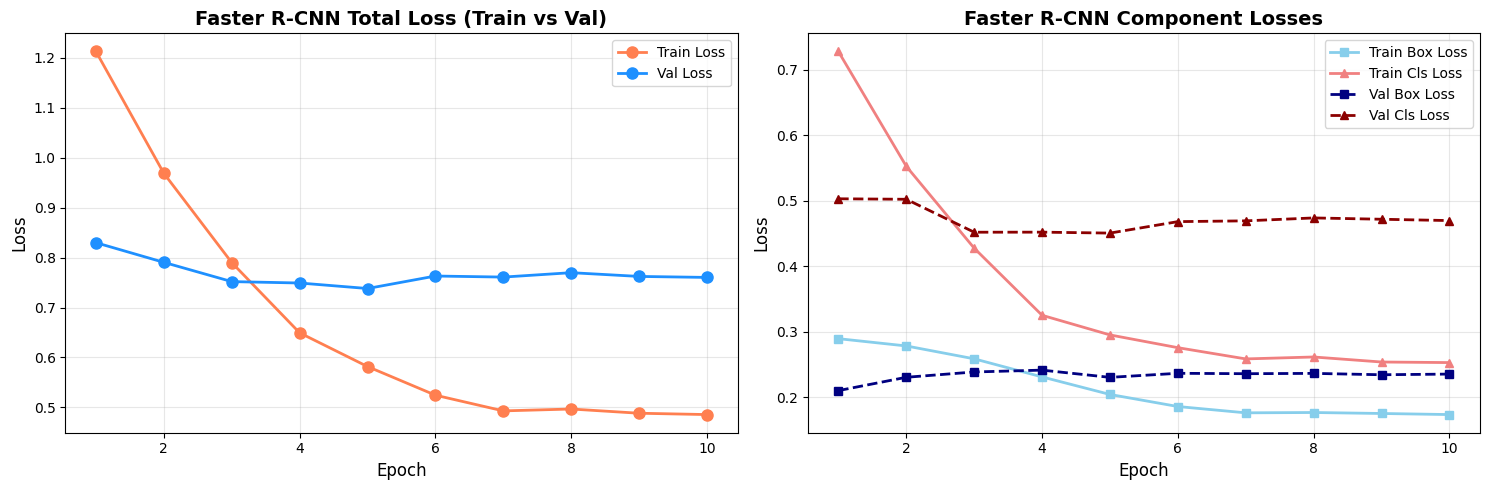

In [11]:
# Plot Faster R-CNN training and validation curves
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot 1: Total Loss (Train vs Val)
axes[0].plot(range(1, num_epochs + 1), training_losses, 
             marker='o', linewidth=2, markersize=8, color='coral', label='Train Loss')
axes[0].plot(range(1, num_epochs + 1), val_losses, 
             marker='o', linewidth=2, markersize=8, color='dodgerblue', label='Val Loss')
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Loss', fontsize=12)
axes[0].set_title('Faster R-CNN Total Loss (Train vs Val)', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3)
axes[0].legend()

# Plot 2: Component Losses (Box and Classification)
axes[1].plot(range(1, num_epochs + 1), training_box_losses, 
             marker='s', linewidth=2, markersize=6, color='skyblue', label='Train Box Loss')
axes[1].plot(range(1, num_epochs + 1), training_cls_losses, 
             marker='^', linewidth=2, markersize=6, color='lightcoral', label='Train Cls Loss')
axes[1].plot(range(1, num_epochs + 1), val_box_losses, 
             marker='s', linewidth=2, markersize=6, color='navy', linestyle='--', label='Val Box Loss')
axes[1].plot(range(1, num_epochs + 1), val_cls_losses, 
             marker='^', linewidth=2, markersize=6, color='darkred', linestyle='--', label='Val Cls Loss')
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Loss', fontsize=12)
axes[1].set_title('Faster R-CNN Component Losses', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3)
axes[1].legend()

plt.tight_layout()
plt.show()

### 2. Single-stage: YOLOv11

We'll train YOLOv11 on the COCO128 dataset using Ultralytics' built-in training pipeline.

In [12]:
# Create separate folders for train/val/test splits
import shutil

# Create split directories
split_dirs = {
    'train': os.path.join(dataset_path, 'splits', 'train'),
    'val': os.path.join(dataset_path, 'splits', 'val'),
    'test': os.path.join(dataset_path, 'splits', 'test')
}

for split_name, split_dir in split_dirs.items():
    os.makedirs(os.path.join(split_dir, 'images'), exist_ok=True)
    os.makedirs(os.path.join(split_dir, 'labels'), exist_ok=True)

print("Creating train/val/test split directories for YOLO...")

# Copy files to appropriate splits
def copy_to_split(indices, split_name):
    for idx in indices:
        img_file = image_files[idx]
        label_file = img_file.replace('.jpg', '.txt').replace('.png', '.txt')
        
        # Copy image
        src_img = os.path.join(images_path, img_file)
        dst_img = os.path.join(split_dirs[split_name], 'images', img_file)
        if not os.path.exists(dst_img):
            shutil.copy2(src_img, dst_img)
        
        # Copy label
        src_label = os.path.join(labels_path, label_file)
        dst_label = os.path.join(split_dirs[split_name], 'labels', label_file)
        if os.path.exists(src_label) and not os.path.exists(dst_label):
            shutil.copy2(src_label, dst_label)

copy_to_split(train_indices, 'train')
copy_to_split(val_indices, 'val')
copy_to_split(test_indices, 'test')

print(f"Copied {len(train_indices)} training images")
print(f"Copied {len(val_indices)} validation images")
print(f"Copied {len(test_indices)} test images")

# Prepare YAML configuration file for YOLOv11 training with proper splits
yaml_content = f"""
# COCO128 dataset configuration with train/val/test split
path: {os.path.abspath(os.path.join(dataset_path, 'splits'))}  # dataset root dir
train: train/images  # train images (relative to 'path')
val: val/images  # val images (relative to 'path')

# Classes
names:
  0: person
  1: bicycle
  2: car
  3: motorcycle
  4: airplane
  5: bus
  6: train
  7: truck
  8: boat
  9: traffic light
  10: fire hydrant
  11: stop sign
  12: parking meter
  13: bench
  14: bird
  15: cat
  16: dog
  17: horse
  18: sheep
  19: cow
  20: elephant
  21: bear
  22: zebra
  23: giraffe
  24: backpack
  25: umbrella
  26: handbag
  27: tie
  28: suitcase
  29: frisbee
  30: skis
  31: snowboard
  32: sports ball
  33: kite
  34: baseball bat
  35: baseball glove
  36: skateboard
  37: surfboard
  38: tennis racket
  39: bottle
  40: wine glass
  41: cup
  42: fork
  43: knife
  44: spoon
  45: bowl
  46: banana
  47: apple
  48: sandwich
  49: orange
  50: broccoli
  51: carrot
  52: hot dog
  53: pizza
  54: donut
  55: cake
  56: chair
  57: couch
  58: potted plant
  59: bed
  60: dining table
  61: toilet
  62: tv
  63: laptop
  64: mouse
  65: remote
  66: keyboard
  67: cell phone
  68: microwave
  69: oven
  70: toaster
  71: sink
  72: refrigerator
  73: book
  74: clock
  75: vase
  76: scissors
  77: teddy bear
  78: hair drier
  79: toothbrush
"""

# Save YAML file
yaml_path = 'coco128_custom.yaml'
with open(yaml_path, 'w') as f:
    f.write(yaml_content)

print(f"YAML configuration saved to: {yaml_path}")

Creating train/val/test split directories for YOLO...
Copied 89 training images
Copied 19 validation images
Copied 20 test images
YAML configuration saved to: coco128_custom.yaml


In [13]:
# Train YOLOv11 on COCO128
print("Training YOLOv11n...")

# Initialize model with YOLOv11n pretrained weights
yolo_model = YOLO('yolo11n.pt')  # Using v11n

# Train the model
results = yolo_model.train(
    data=yaml_path,
    epochs=10,
    imgsz=640,
    batch=8,
    device=device,
    project='model_task2',
    name='yolov11n_coco128_run',
    verbose=True,
    patience=5,
    save=True
)

print("YOLOv11n training completed!")
print(f"Best model saved at: {yolo_model.trainer.best}")

Training YOLOv11n...
New https://pypi.org/project/ultralytics/8.3.223 available  Update with 'pip install -U ultralytics'
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=coco128_custom.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=10, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=yolov11n_coco128_run2, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, pati

c:\Users\USER\Documents\Dechathon_N\AIT\.venv\Lib\site-packages\ultralytics\nn\modules\block.py:1357: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\Context.cpp:315.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
c:\Users\USER\Documents\Dechathon_N\AIT\.venv\Lib\site-packages\ultralytics\nn\modules\block.py:1359: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `a

AMP: checks passed 
train: Fast image access  (ping: 0.00.0 ms, read: 10.06.2 MB/s, size: 79.2 KB)
train: Scanning C:\Users\USER\Documents\Dechathon_N\AIT\Computer Vision\AIT-Computer-Vision-Assignment2\coco128\splits\train\labels... 88 images, 1 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 89/89 1.1Kit/s 0.1s
train: New cache created: C:\Users\USER\Documents\Dechathon_N\AIT\Computer Vision\AIT-Computer-Vision-Assignment2\coco128\splits\train\labels.cache
val: Fast image access  (ping: 0.00.0 ms, read: 5.42.1 MB/s, size: 41.6 KB)
val: Scanning C:\Users\USER\Documents\Dechathon_N\AIT\Computer Vision\AIT-Computer-Vision-Assignment2\coco128\splits\val\labels... 18 images, 1 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 19/19 652.6it/s 0.0s
val: New cache created: C:\Users\USER\Documents\Dechathon_N\AIT\Computer Vision\AIT-Computer-Vision-Assignment2\coco128\splits\val\labels.cache
Plotting labels to C:\Users\USER\Documents\Dechathon_N\AIT\Computer Vision\AIT-Computer-Vision-Assignment2\model_tas

c:\Users\USER\Documents\Dechathon_N\AIT\.venv\Lib\site-packages\ultralytics\nn\modules\block.py:1357: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\Context.cpp:315.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
c:\Users\USER\Documents\Dechathon_N\AIT\.venv\Lib\site-packages\ultralytics\nn\modules\block.py:1359: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `a

       1/10       7.1G      1.242      2.081      1.233         96        640: 8% ━─────────── 1/12 2.5it/s 3.4s<4.4s

c:\Users\USER\Documents\Dechathon_N\AIT\.venv\Lib\site-packages\torch\autograd\graph.py:841: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\Context.cpp:315.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


       1/10      7.14G      1.347      1.658      1.314          6        640: 100% ━━━━━━━━━━━━ 12/12 1.8it/s 6.6s0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 2/2 1.5it/s 1.3s2.4s
                   all         19         88      0.518      0.842        0.8      0.636

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
       2/10      7.14G      1.117      1.456      1.219         45        640: 8% ━─────────── 1/12 1.9it/s 0.2s<5.9s

c:\Users\USER\Documents\Dechathon_N\AIT\.venv\Lib\site-packages\ultralytics\nn\modules\block.py:1357: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\Context.cpp:315.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
c:\Users\USER\Documents\Dechathon_N\AIT\.venv\Lib\site-packages\ultralytics\nn\modules\block.py:1359: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `a

       2/10      7.15G      1.372      1.959       1.21          2        640: 100% ━━━━━━━━━━━━ 12/12 14.3it/s 0.8s0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 2/2 19.9it/s 0.1s
                   all         19         88       0.55      0.831      0.814       0.62

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
       3/10      7.16G      1.015      1.123      1.092         56        640: 8% ━─────────── 1/12 2.2it/s 0.1s<5.0s

c:\Users\USER\Documents\Dechathon_N\AIT\.venv\Lib\site-packages\ultralytics\nn\modules\block.py:1357: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\Context.cpp:315.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
c:\Users\USER\Documents\Dechathon_N\AIT\.venv\Lib\site-packages\ultralytics\nn\modules\block.py:1359: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `a

       3/10      7.17G      1.224      1.329      1.166          6        640: 100% ━━━━━━━━━━━━ 12/12 15.0it/s 0.8s0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 2/2 20.2it/s 0.1s
                   all         19         88      0.583      0.826       0.84      0.617

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
       4/10      7.17G      1.181      1.633      1.282         61        640: 8% ━─────────── 1/12 2.1it/s 0.1s<5.4s

c:\Users\USER\Documents\Dechathon_N\AIT\.venv\Lib\site-packages\ultralytics\nn\modules\block.py:1357: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\Context.cpp:315.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
c:\Users\USER\Documents\Dechathon_N\AIT\.venv\Lib\site-packages\ultralytics\nn\modules\block.py:1359: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `a

       4/10      7.18G      1.192      1.409      1.228          3        640: 100% ━━━━━━━━━━━━ 12/12 15.2it/s 0.8s0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 2/2 19.7it/s 0.1s
                   all         19         88      0.572      0.836       0.84      0.627

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
       5/10      7.19G      1.183      1.174      1.122         62        640: 8% ━─────────── 1/12 2.0it/s 0.2s<5.5s

c:\Users\USER\Documents\Dechathon_N\AIT\.venv\Lib\site-packages\ultralytics\nn\modules\block.py:1357: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\Context.cpp:315.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
c:\Users\USER\Documents\Dechathon_N\AIT\.venv\Lib\site-packages\ultralytics\nn\modules\block.py:1359: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `a

       5/10       7.2G       1.21      1.433      1.174          3        640: 100% ━━━━━━━━━━━━ 12/12 15.3it/s 0.8s0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 2/2 20.1it/s 0.1s
                   all         19         88      0.576      0.792      0.836       0.62

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
       6/10       7.2G      1.332      1.512      1.192        108        640: 8% ━─────────── 1/12 2.4it/s 0.1s<4.5s

c:\Users\USER\Documents\Dechathon_N\AIT\.venv\Lib\site-packages\ultralytics\nn\modules\block.py:1357: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\Context.cpp:315.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
c:\Users\USER\Documents\Dechathon_N\AIT\.venv\Lib\site-packages\ultralytics\nn\modules\block.py:1359: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `a

       6/10       7.2G      1.142      1.428      1.168          4        640: 100% ━━━━━━━━━━━━ 12/12 15.8it/s 0.8s0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 2/2 20.0it/s 0.1s
                   all         19         88       0.55      0.798      0.835      0.622
EarlyStopping: Training stopped early as no improvement observed in last 5 epochs. Best results observed at epoch 1, best model saved as best.pt.
To update EarlyStopping(patience=5) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.

6 epochs completed in 0.004 hours.
Optimizer stripped from C:\Users\USER\Documents\Dechathon_N\AIT\Computer Vision\AIT-Computer-Vision-Assignment2\model_task2\yolov11n_coco128_run2\weights\last.pt, 5.5MB
Optimizer stripped from C:\Users\USER\Documents\Dechathon_N\AIT\Computer Vision\AIT-Computer-Vision-Assignment2\model_task2\yolov11n_coco128_run2\weights\best.pt, 5.5MB

Validating C:\

In [14]:
# Load the best trained YOLOv11n model
yolo_model = YOLO('model_task2/yolov11n_coco128_run/weights/best.pt')
yolo_model.to(device)

print("YOLOv11n best model loaded successfully")
print(f"Model path: model_task2/yolov11n_coco128_run/weights/best.pt")

# Get model size
yolo_size = sum(p.numel() for p in yolo_model.model.parameters()) / 1e6
print(f"YOLOv11n parameters: {yolo_size:.2f}M")

# Get model file size
yolo_file_size = os.path.getsize('model_task2/yolov11n_coco128_run/weights/best.pt') / (1024 * 1024)
print(f"YOLOv11n model file size: {yolo_file_size:.2f} MB")

YOLOv11n best model loaded successfully
Model path: model_task2/yolov11n_coco128_run/weights/best.pt
YOLOv11n parameters: 2.62M
YOLOv11n model file size: 5.27 MB


In [15]:
# Display training results
print("\n" + "="*70)
print("TRAINING SUMMARY")
print("="*70)

# YOLOv11 training metrics
yolo_results_path = 'model_task2/yolov11n_coco128_run/results.csv'
if os.path.exists(yolo_results_path):
    results_df = pd.read_csv(yolo_results_path)
    results_df = results_df.rename(columns=lambda x: x.strip())
    
    print("\nYOLOv11n Training Metrics (Last 3 Epochs):")
    print(results_df[['epoch', 'train/box_loss', 'train/cls_loss', 'metrics/mAP50(B)']].tail(3).to_string(index=False))
else:
    print("\nYOLOv11n results not found")

# Faster R-CNN training metrics
rcnn_results_path = 'model_task2/faster_rcnn_training_results.csv'
if os.path.exists(rcnn_results_path):
    rcnn_df = pd.read_csv(rcnn_results_path)
    print("\nFaster R-CNN Training Metrics (Last 3 Epochs):")
    print(rcnn_df[['epoch', 'train/total_loss', 'train/box_loss', 'train/cls_loss']].tail(3).to_string(index=False))
else:
    print("\nFaster R-CNN Training Losses:")
    for i, loss in enumerate(training_losses, 1):
        print(f"  Epoch {i}: {loss:.4f}")

print("="*70)
print("\nBoth models saved in 'model_task2' folder:")
print("   - Faster R-CNN: model_task2/faster_rcnn_coco128.pth")
print("   - YOLOv11n: model_task2/yolov11n_coco128_run/weights/best.pt")
print("="*70)


TRAINING SUMMARY

YOLOv11n Training Metrics (Last 3 Epochs):
 epoch  train/box_loss  train/cls_loss  metrics/mAP50(B)
     8         1.12128         1.13927           0.70767
     9         1.08039         1.10381           0.70854
    10         1.10264         1.09238           0.70905

Faster R-CNN Training Metrics (Last 3 Epochs):
 epoch  train/total_loss  train/box_loss  train/cls_loss
     8          0.496876        0.176957        0.261706
     9          0.488431        0.175471        0.254027
    10          0.485764        0.173814        0.253159

Both models saved in 'model_task2' folder:
   - Faster R-CNN: model_task2/faster_rcnn_coco128.pth
   - YOLOv11n: model_task2/yolov11n_coco128_run/weights/best.pt


Training comparison plot saved to: model_task2/training_comparison.png


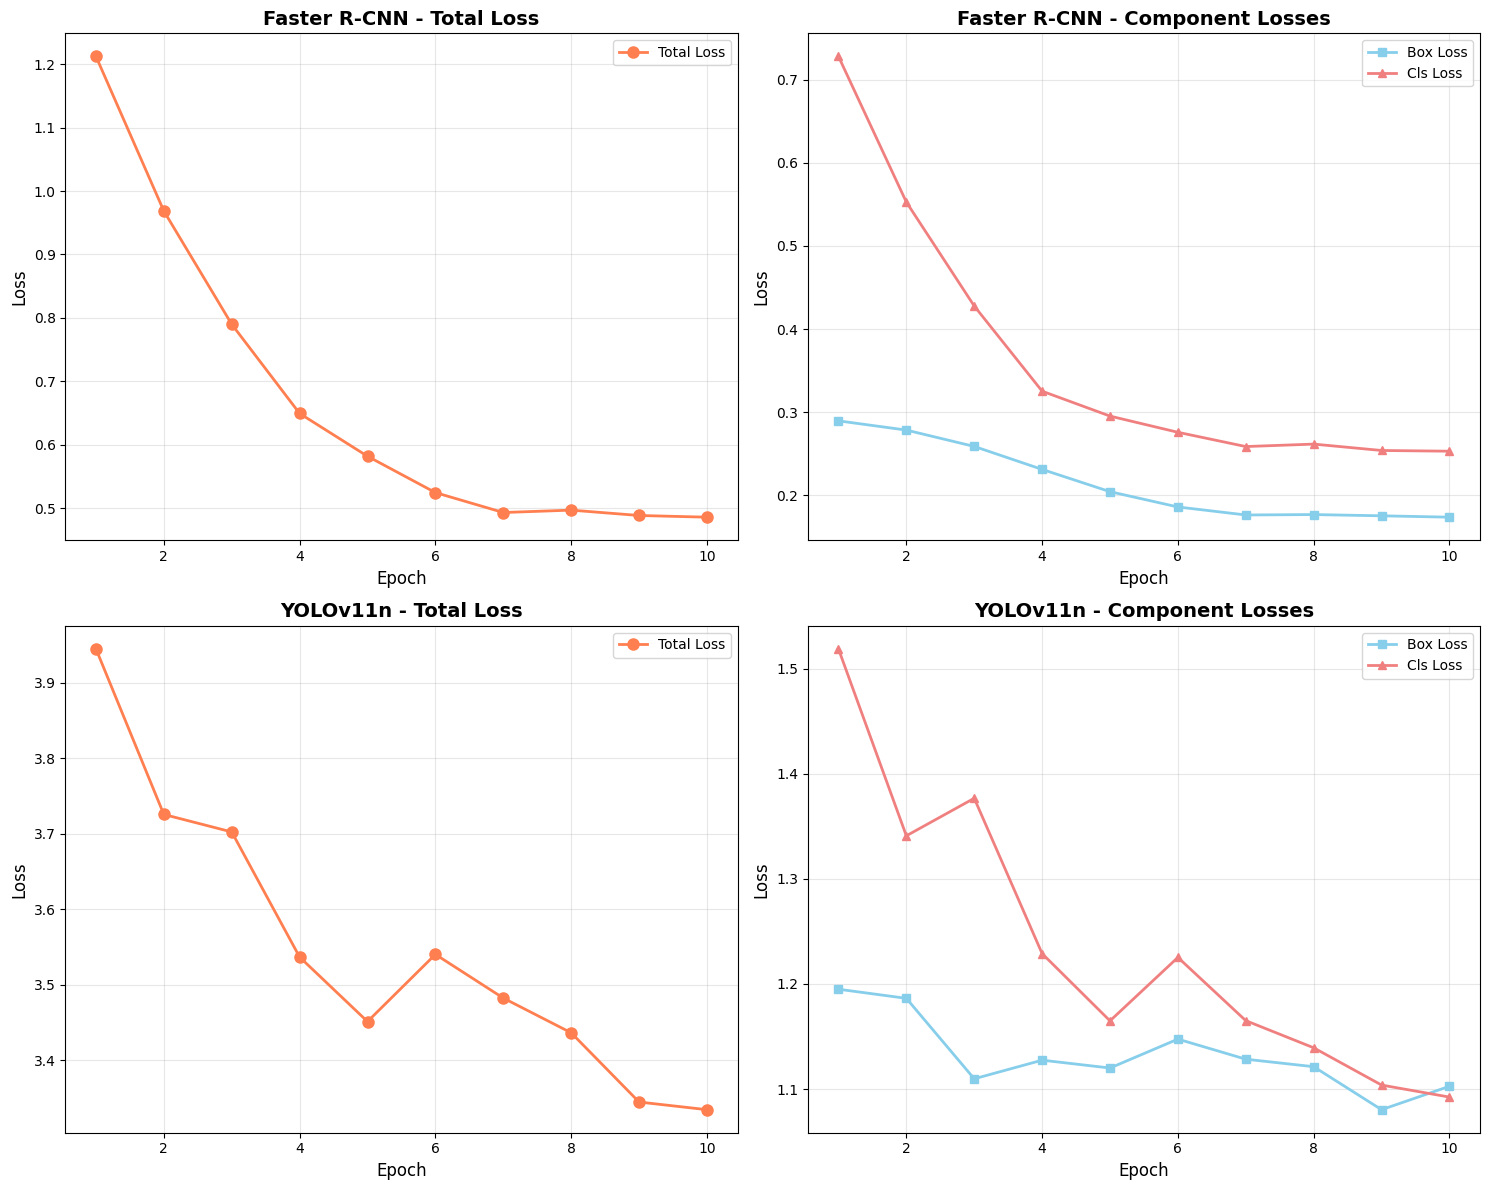

In [16]:
# Plot training curves comparison
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Load both training results
yolo_results_path = 'model_task2/yolov11n_coco128_run/results.csv'
rcnn_results_path = 'model_task2/faster_rcnn_training_results.csv'

# Row 1: Faster R-CNN
axes[0, 0].plot(range(1, len(training_losses) + 1), training_losses, 
                marker='o', linewidth=2, markersize=8, color='coral', label='Total Loss')
axes[0, 0].set_xlabel('Epoch', fontsize=12)
axes[0, 0].set_ylabel('Loss', fontsize=12)
axes[0, 0].set_title('Faster R-CNN - Total Loss', fontsize=14, fontweight='bold')
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].legend()

axes[0, 1].plot(range(1, len(training_box_losses) + 1), training_box_losses, 
                marker='s', linewidth=2, markersize=6, color='skyblue', label='Box Loss')
axes[0, 1].plot(range(1, len(training_cls_losses) + 1), training_cls_losses, 
                marker='^', linewidth=2, markersize=6, color='lightcoral', label='Cls Loss')
axes[0, 1].set_xlabel('Epoch', fontsize=12)
axes[0, 1].set_ylabel('Loss', fontsize=12)
axes[0, 1].set_title('Faster R-CNN - Component Losses', fontsize=14, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].legend()

# Row 2: YOLOv11
if os.path.exists(yolo_results_path):
    results_df = pd.read_csv(yolo_results_path)
    results_df = results_df.rename(columns=lambda x: x.strip())
    
    # Total loss (sum of box + cls + dfl losses)
    total_loss = results_df['train/box_loss'] + results_df['train/cls_loss'] + results_df['train/dfl_loss']
    axes[1, 0].plot(results_df['epoch'], total_loss, 
                    marker='o', linewidth=2, markersize=8, color='coral', label='Total Loss')
    axes[1, 0].set_xlabel('Epoch', fontsize=12)
    axes[1, 0].set_ylabel('Loss', fontsize=12)
    axes[1, 0].set_title('YOLOv11n - Total Loss', fontsize=14, fontweight='bold')
    axes[1, 0].grid(True, alpha=0.3)
    axes[1, 0].legend()
    
    # Component losses
    axes[1, 1].plot(results_df['epoch'], results_df['train/box_loss'], 
                    marker='s', linewidth=2, markersize=6, color='skyblue', label='Box Loss')
    axes[1, 1].plot(results_df['epoch'], results_df['train/cls_loss'], 
                    marker='^', linewidth=2, markersize=6, color='lightcoral', label='Cls Loss')
    axes[1, 1].set_xlabel('Epoch', fontsize=12)
    axes[1, 1].set_ylabel('Loss', fontsize=12)
    axes[1, 1].set_title('YOLOv11n - Component Losses', fontsize=14, fontweight='bold')
    axes[1, 1].grid(True, alpha=0.3)
    axes[1, 1].legend()
else:
    axes[1, 0].text(0.5, 0.5, 'YOLOv11n results not available', 
                    ha='center', va='center', fontsize=12)
    axes[1, 0].set_title('YOLOv11n - Total Loss', fontsize=14, fontweight='bold')
    axes[1, 1].text(0.5, 0.5, 'YOLOv11n results not available', 
                    ha='center', va='center', fontsize=12)
    axes[1, 1].set_title('YOLOv11n - Component Losses', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig('model_task2/training_comparison.png', dpi=150, bbox_inches='tight')
print("Training comparison plot saved to: model_task2/training_comparison.png")
plt.show()

## Run both model on same dataset

In [17]:
# Helper function for Faster R-CNN inference
def run_faster_rcnn(model, image_path, conf_threshold=0.5):
    """Run Faster R-CNN on a single image"""
    # Load and preprocess image
    image = Image.open(image_path).convert('RGB')
    image_tensor = transforms.ToTensor()(image).unsqueeze(0).to(device)
    
    # Run inference
    with torch.no_grad():
        predictions = model(image_tensor)[0]
    
    # Filter by confidence threshold
    keep = predictions['scores'] >= conf_threshold
    boxes = predictions['boxes'][keep].cpu().numpy()
    labels = predictions['labels'][keep].cpu().numpy()
    scores = predictions['scores'][keep].cpu().numpy()
    
    return boxes, labels, scores

# Helper function for YOLOv11 inference
def run_yolo(model, image_path, conf_threshold=0.5):
    """Run YOLOv11 on a single image"""
    results = model(image_path, conf=conf_threshold, verbose=False)[0]
    
    boxes = results.boxes.xyxy.cpu().numpy()
    labels = results.boxes.cls.cpu().numpy().astype(int)
    scores = results.boxes.conf.cpu().numpy()
    
    return boxes, labels, scores

print("Inference functions defined")

Inference functions defined


In [18]:
# Run both models on TEST SET ONLY and collect predictions
print("Running inference on TEST SET...")

faster_rcnn_predictions = []
yolo_predictions = []

conf_threshold = 0.25  # Lower threshold to get more detections for mAP calculation

# Run inference ONLY on test set (held-out data)
for idx in range(len(test_dataset)):
    sample = test_dataset[idx]
    image_path = sample['image_path']
    
    # Faster R-CNN
    rcnn_boxes, rcnn_labels, rcnn_scores = run_faster_rcnn(faster_rcnn, image_path, conf_threshold)
    faster_rcnn_predictions.append({
        'boxes': rcnn_boxes,
        'labels': rcnn_labels,
        'scores': rcnn_scores,
        'gt_boxes': sample['boxes'].numpy(),
        'gt_labels': sample['labels'].numpy()
    })
    
    # YOLOv11
    yolo_boxes, yolo_labels, yolo_scores = run_yolo(yolo_model, image_path, conf_threshold)
    yolo_predictions.append({
        'boxes': yolo_boxes,
        'labels': yolo_labels,
        'scores': yolo_scores,
        'gt_boxes': sample['boxes'].numpy(),
        'gt_labels': sample['labels'].numpy()
    })

print(f"Inference complete on {len(test_dataset)} TEST images (unseen during training)")
print("This ensures evaluation on held-out data for valid performance metrics")

Running inference on TEST SET...
Inference complete on 20 TEST images (unseen during training)
This ensures evaluation on held-out data for valid performance metrics


## Measure Performance Metrics
   - Detection accuracy (mAP or precision-recall curves)
   - Inference speed (FPS)
   - Model size and memory usage

In [19]:
# Calculate IoU (Intersection over Union)
def calculate_iou(box1, box2):
    """Calculate IoU between two boxes [x1, y1, x2, y2]"""
    x1 = max(box1[0], box2[0])
    y1 = max(box1[1], box2[1])
    x2 = min(box1[2], box2[2])
    y2 = min(box1[3], box2[3])
    
    intersection = max(0, x2 - x1) * max(0, y2 - y1)
    area1 = (box1[2] - box1[0]) * (box1[3] - box1[1])
    area2 = (box2[2] - box2[0]) * (box2[3] - box2[1])
    union = area1 + area2 - intersection
    
    return intersection / union if union > 0 else 0

# Calculate Average Precision (AP) for object detection
def calculate_ap(predictions, ground_truths, iou_threshold=0.5, adjust_labels=False):
    """
    Calculate Average Precision for object detection
    
    Args:
        predictions: List of prediction dicts with 'boxes', 'scores', 'labels'
        ground_truths: List of ground truth dicts with 'gt_boxes', 'gt_labels'
        iou_threshold: IoU threshold for matching
        adjust_labels: If True, adjust Faster R-CNN labels (1-indexed) to match YOLO (0-indexed)
    """
    # Collect all predictions and ground truths
    all_predictions = []
    all_ground_truths = []
    
    for pred, gt in zip(predictions, ground_truths):
        pred_boxes = pred['boxes']
        pred_scores = pred['scores']
        pred_labels = pred['labels']
        
        gt_boxes = gt['gt_boxes']
        gt_labels = gt['gt_labels']
        
        for i in range(len(pred_boxes)):
            # Adjust label indexing if needed (Faster R-CNN: 1-indexed, YOLO: 0-indexed)
            label = pred_labels[i] - 1 if adjust_labels else pred_labels[i]
            all_predictions.append({
                'box': pred_boxes[i],
                'score': pred_scores[i],
                'label': label,
                'image_idx': len(all_ground_truths)
            })
        
        all_ground_truths.append({
            'boxes': gt_boxes,
            'labels': gt_labels,
            'detected': [False] * len(gt_boxes)
        })
    
    # Sort predictions by score (descending)
    all_predictions.sort(key=lambda x: x['score'], reverse=True)
    
    # Calculate precision and recall
    true_positives = []
    false_positives = []
    
    for pred in all_predictions:
        image_idx = pred['image_idx']
        gt = all_ground_truths[image_idx]
        
        best_iou = 0
        best_gt_idx = -1
        
        # Find best matching ground truth
        for gt_idx in range(len(gt['boxes'])):
            if gt['labels'][gt_idx] == pred['label'] and not gt['detected'][gt_idx]:
                iou = calculate_iou(pred['box'], gt['boxes'][gt_idx])
                if iou > best_iou:
                    best_iou = iou
                    best_gt_idx = gt_idx
        
        # Check if prediction is TP or FP
        if best_iou >= iou_threshold and best_gt_idx >= 0:
            gt['detected'][best_gt_idx] = True
            true_positives.append(1)
            false_positives.append(0)
        else:
            true_positives.append(0)
            false_positives.append(1)
    
    # Calculate cumulative sums
    tp_cumsum = np.cumsum(true_positives)
    fp_cumsum = np.cumsum(false_positives)
    
    # Total ground truths
    total_gt = sum(len(gt['boxes']) for gt in all_ground_truths)
    
    # Calculate precision and recall
    recalls = tp_cumsum / (total_gt + 1e-6)
    precisions = tp_cumsum / (tp_cumsum + fp_cumsum + 1e-6)
    
    # Calculate AP using 11-point interpolation
    ap = 0
    for t in np.linspace(0, 1, 11):
        if np.sum(recalls >= t) == 0:
            p = 0
        else:
            p = np.max(precisions[recalls >= t])
        ap += p / 11
    
    return ap, precisions, recalls

print("Evaluation functions defined")

Evaluation functions defined


In [20]:
# Calculate mAP (mean Average Precision) for both models
print("Calculating mAP for Faster R-CNN...")
# Note: Faster R-CNN uses 1-indexed labels, so we adjust them to match ground truth (0-indexed)
rcnn_ap, rcnn_precisions, rcnn_recalls = calculate_ap(faster_rcnn_predictions, faster_rcnn_predictions, iou_threshold=0.5, adjust_labels=True)

print("Calculating mAP for YOLOv11...")
# YOLOv11 uses 0-indexed labels, matching ground truth
yolo_ap, yolo_precisions, yolo_recalls = calculate_ap(yolo_predictions, yolo_predictions, iou_threshold=0.5, adjust_labels=False)

print(f"\nFaster R-CNN mAP@0.5: {rcnn_ap:.4f}")
print(f"YOLOv11 mAP@0.5: {yolo_ap:.4f}")

Calculating mAP for Faster R-CNN...
Calculating mAP for YOLOv11...

Faster R-CNN mAP@0.5: 0.3060
YOLOv11 mAP@0.5: 0.5800


In [21]:
# Calculate per-class Average Precision
def calculate_per_class_ap(predictions, ground_truths, num_classes=80, iou_threshold=0.5, adjust_labels=False):
    """Calculate AP for each class"""
    class_aps = {}
    
    for class_id in range(num_classes):
        # Filter predictions and ground truths for this class
        class_predictions = []
        class_ground_truths = []
        
        for pred, gt in zip(predictions, ground_truths):
            pred_boxes = pred['boxes']
            pred_scores = pred['scores']
            pred_labels = pred['labels']
            
            gt_boxes = gt['gt_boxes']
            gt_labels = gt['gt_labels']
            
            # Adjust labels if needed
            if adjust_labels:
                pred_labels = pred_labels - 1
            
            # Filter for current class
            class_pred_mask = (pred_labels == class_id)
            class_gt_mask = (gt_labels == class_id)
            
            if np.any(class_pred_mask):
                class_predictions.append({
                    'boxes': pred_boxes[class_pred_mask],
                    'scores': pred_scores[class_pred_mask],
                    'labels': np.full(np.sum(class_pred_mask), class_id),
                    'image_idx': len(class_ground_truths)
                })
            
            if np.any(class_gt_mask):
                class_ground_truths.append({
                    'gt_boxes': gt_boxes[class_gt_mask],
                    'gt_labels': np.full(np.sum(class_gt_mask), class_id)
                })
            else:
                class_ground_truths.append({
                    'gt_boxes': np.array([]),
                    'gt_labels': np.array([])
                })
        
        # Calculate AP if there are any ground truths for this class
        num_gt = sum(len(gt['gt_boxes']) for gt in class_ground_truths)
        if num_gt > 0:
            ap, _, _ = calculate_ap(class_predictions, class_ground_truths, 
                                   iou_threshold=iou_threshold, adjust_labels=False)
            class_aps[class_id] = {'ap': ap, 'num_gt': num_gt}
    
    return class_aps

print("Calculating per-class Average Precision...")
rcnn_class_aps = calculate_per_class_ap(faster_rcnn_predictions, faster_rcnn_predictions, 
                                        num_classes=80, iou_threshold=0.5, adjust_labels=True)
yolo_class_aps = calculate_per_class_ap(yolo_predictions, yolo_predictions, 
                                        num_classes=80, iou_threshold=0.5, adjust_labels=False)

# Display top classes by number of ground truth instances
print("\n=== PER-CLASS PERFORMANCE (Top 10 classes by frequency) ===")
sorted_classes = sorted(rcnn_class_aps.items(), key=lambda x: x[1]['num_gt'], reverse=True)[:10]

per_class_data = []
for class_id, metrics in sorted_classes:
    class_name = COCO_CLASSES[class_id] if class_id < len(COCO_CLASSES) else f'Class {class_id}'
    rcnn_ap = metrics['ap']
    yolo_ap = yolo_class_aps.get(class_id, {}).get('ap', 0.0)
    num_instances = metrics['num_gt']
    
    per_class_data.append({
        'Class': class_name,
        'Instances': num_instances,
        'Faster R-CNN AP': f'{rcnn_ap:.4f}',
        'YOLOv11 AP': f'{yolo_ap:.4f}'
    })

per_class_df = pd.DataFrame(per_class_data)
print(per_class_df.to_string(index=False))
print("="*70)


Calculating per-class Average Precision...

=== PER-CLASS PERFORMANCE (Top 10 classes by frequency) ===
       Class  Instances Faster R-CNN AP YOLOv11 AP
      person         35          0.0182     0.0455
        book         21          0.0000     0.0000
       chair         13          0.0000     0.0000
potted plant          4          0.0000     0.0000
         bus          3          0.4545     0.0000
         dog          3          0.0000     0.0000
  cell phone          3          0.0000     0.0000
  teddy bear          3          0.0000     0.0000
    elephant          2          0.0000     0.0000
    backpack          2          0.0000     0.0000


In [22]:
# Calculate detection statistics: TP, FP, FN
def calculate_detection_stats(predictions, ground_truths, iou_threshold=0.5, adjust_labels=False):
    """Calculate True Positives, False Positives, False Negatives"""
    total_tp = 0
    total_fp = 0
    total_fn = 0
    
    for pred, gt in zip(predictions, ground_truths):
        pred_boxes = pred['boxes']
        pred_labels = pred['labels'].copy()
        gt_boxes = gt['gt_boxes']
        gt_labels = gt['gt_labels']
        
        # Adjust labels if needed
        if adjust_labels:
            pred_labels = pred_labels - 1
        
        # Track which ground truths have been matched
        matched_gt = set()
        tp = 0
        fp = 0
        
        # For each prediction, find best matching ground truth
        for i in range(len(pred_boxes)):
            best_iou = 0
            best_gt_idx = -1
            
            for j in range(len(gt_boxes)):
                if j in matched_gt:
                    continue
                
                if pred_labels[i] == gt_labels[j]:
                    iou = calculate_iou(pred_boxes[i], gt_boxes[j])
                    if iou > best_iou:
                        best_iou = iou
                        best_gt_idx = j
            
            if best_iou >= iou_threshold and best_gt_idx >= 0:
                tp += 1
                matched_gt.add(best_gt_idx)
            else:
                fp += 1
        
        # False negatives are unmatched ground truths
        fn = len(gt_boxes) - len(matched_gt)
        
        total_tp += tp
        total_fp += fp
        total_fn += fn
    
    return total_tp, total_fp, total_fn

print("Calculating detection statistics...")

# Calculate for both models
rcnn_tp, rcnn_fp, rcnn_fn = calculate_detection_stats(
    faster_rcnn_predictions, faster_rcnn_predictions, 
    iou_threshold=0.5, adjust_labels=True
)

yolo_tp, yolo_fp, yolo_fn = calculate_detection_stats(
    yolo_predictions, yolo_predictions, 
    iou_threshold=0.5, adjust_labels=False
)

# Calculate precision, recall, F1
def calc_metrics(tp, fp, fn):
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    return precision, recall, f1

rcnn_precision, rcnn_recall, rcnn_f1 = calc_metrics(rcnn_tp, rcnn_fp, rcnn_fn)
yolo_precision, yolo_recall, yolo_f1 = calc_metrics(yolo_tp, yolo_fp, yolo_fn)

print("\n=== DETECTION STATISTICS (IoU=0.5) ===")
stats_data = {
    'Metric': ['True Positives', 'False Positives', 'False Negatives', 'Precision', 'Recall', 'F1-Score'],
    'Faster R-CNN': [
        rcnn_tp, rcnn_fp, rcnn_fn, 
        f'{rcnn_precision:.4f}', f'{rcnn_recall:.4f}', f'{rcnn_f1:.4f}'
    ],
    'YOLOv11': [
        yolo_tp, yolo_fp, yolo_fn,
        f'{yolo_precision:.4f}', f'{yolo_recall:.4f}', f'{yolo_f1:.4f}'
    ]
}

stats_df = pd.DataFrame(stats_data)
print(stats_df.to_string(index=False))
print("="*70)


Calculating detection statistics...

=== DETECTION STATISTICS (IoU=0.5) ===
         Metric Faster R-CNN YOLOv11
 True Positives           40      78
False Positives           88      53
False Negatives           83      45
      Precision       0.3125  0.5954
         Recall       0.3252  0.6341
       F1-Score       0.3187  0.6142


Detection statistics plot saved to: model_task2/detection_statistics.png


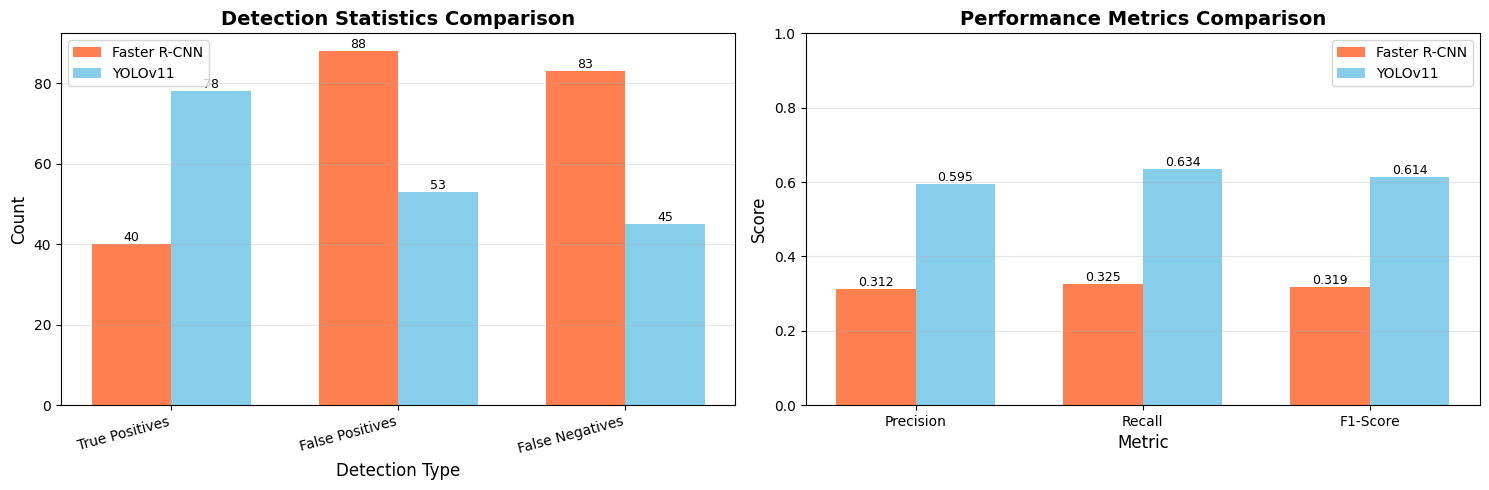

In [23]:
# Visualize detection statistics
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot 1: TP, FP, FN comparison
categories = ['True Positives', 'False Positives', 'False Negatives']
rcnn_values = [rcnn_tp, rcnn_fp, rcnn_fn]
yolo_values = [yolo_tp, yolo_fp, yolo_fn]

x = np.arange(len(categories))
width = 0.35

bars1 = axes[0].bar(x - width/2, rcnn_values, width, label='Faster R-CNN', color='coral')
bars2 = axes[0].bar(x + width/2, yolo_values, width, label='YOLOv11', color='skyblue')

axes[0].set_xlabel('Detection Type', fontsize=12)
axes[0].set_ylabel('Count', fontsize=12)
axes[0].set_title('Detection Statistics Comparison', fontsize=14, fontweight='bold')
axes[0].set_xticks(x)
axes[0].set_xticklabels(categories, rotation=15, ha='right')
axes[0].legend()
axes[0].grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        axes[0].text(bar.get_x() + bar.get_width()/2., height,
                f'{int(height)}',
                ha='center', va='bottom', fontsize=9)

# Plot 2: Precision, Recall, F1 comparison
metrics = ['Precision', 'Recall', 'F1-Score']
rcnn_metric_values = [rcnn_precision, rcnn_recall, rcnn_f1]
yolo_metric_values = [yolo_precision, yolo_recall, yolo_f1]

x2 = np.arange(len(metrics))
bars3 = axes[1].bar(x2 - width/2, rcnn_metric_values, width, label='Faster R-CNN', color='coral')
bars4 = axes[1].bar(x2 + width/2, yolo_metric_values, width, label='YOLOv11', color='skyblue')

axes[1].set_xlabel('Metric', fontsize=12)
axes[1].set_ylabel('Score', fontsize=12)
axes[1].set_title('Performance Metrics Comparison', fontsize=14, fontweight='bold')
axes[1].set_xticks(x2)
axes[1].set_xticklabels(metrics)
axes[1].set_ylim([0, 1.0])
axes[1].legend()
axes[1].grid(True, alpha=0.3, axis='y')

# Add value labels
for bars in [bars3, bars4]:
    for bar in bars:
        height = bar.get_height()
        axes[1].text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}',
                ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.savefig('model_task2/detection_statistics.png', dpi=150, bbox_inches='tight')
print("Detection statistics plot saved to: model_task2/detection_statistics.png")
plt.show()


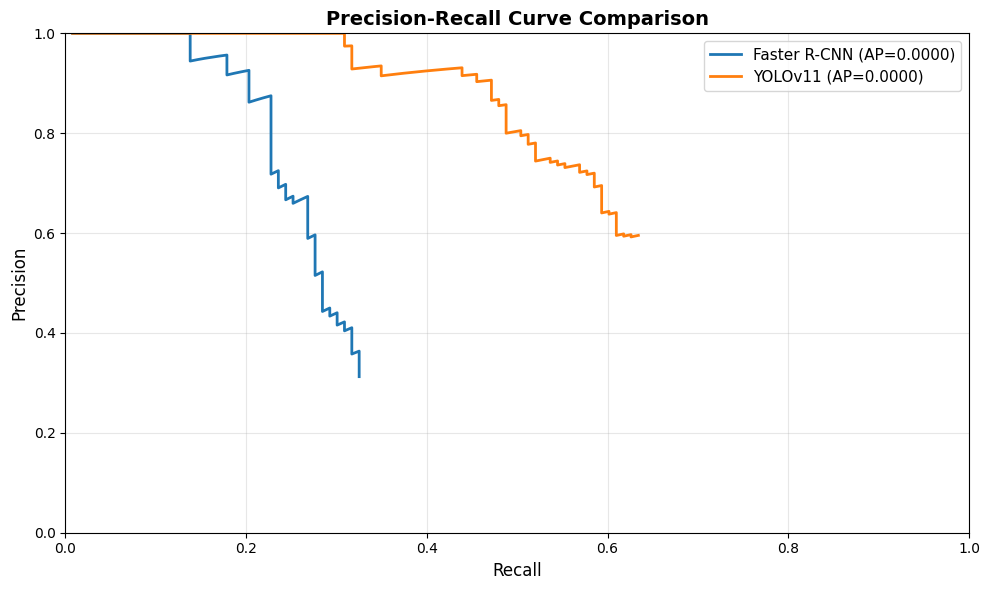

In [24]:
# Plot Precision-Recall curves
plt.figure(figsize=(10, 6))
plt.plot(rcnn_recalls, rcnn_precisions, label=f'Faster R-CNN (AP={rcnn_ap:.4f})', linewidth=2)
plt.plot(yolo_recalls, yolo_precisions, label=f'YOLOv11 (AP={yolo_ap:.4f})', linewidth=2)
plt.xlabel('Recall', fontsize=12)
plt.ylabel('Precision', fontsize=12)
plt.title('Precision-Recall Curve Comparison', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.tight_layout()
plt.show()

In [25]:
# Measure inference speed (FPS)
print("Measuring inference speed...")

# Select a subset of images for FPS measurement
num_warmup = 10
num_test = 50
test_images = image_files[:num_test]

# Warmup runs
print("Warming up models...")
for i in range(num_warmup):
    img_path = os.path.join(images_path, test_images[i % len(test_images)])
    _ = run_faster_rcnn(faster_rcnn, img_path, conf_threshold=0.5)
    _ = run_yolo(yolo_model, img_path, conf_threshold=0.5)

# Faster R-CNN speed test
print("Testing Faster R-CNN speed...")
start_time = time.time()
for img_name in test_images:
    img_path = os.path.join(images_path, img_name)
    _ = run_faster_rcnn(faster_rcnn, img_path, conf_threshold=0.5)
rcnn_time = time.time() - start_time
rcnn_fps = num_test / rcnn_time

# YOLOv11 speed test
print("Testing YOLOv11 speed...")
start_time = time.time()
for img_name in test_images:
    img_path = os.path.join(images_path, img_name)
    _ = run_yolo(yolo_model, img_path, conf_threshold=0.5)
yolo_time = time.time() - start_time
yolo_fps = num_test / yolo_time

print(f"\nFaster R-CNN: {rcnn_fps:.2f} FPS (avg time: {rcnn_time/num_test*1000:.2f} ms/image)")
print(f"YOLOv11: {yolo_fps:.2f} FPS (avg time: {yolo_time/num_test*1000:.2f} ms/image)")

Measuring inference speed...
Warming up models...
Testing Faster R-CNN speed...
Testing YOLOv11 speed...

Faster R-CNN: 21.21 FPS (avg time: 47.14 ms/image)
YOLOv11: 111.25 FPS (avg time: 8.99 ms/image)


In [26]:
# Measure memory usage
print("Measuring memory usage...")

# Get GPU memory usage for Faster R-CNN
torch.cuda.reset_peak_memory_stats(device)
torch.cuda.empty_cache()

# Run a few inferences
for i in range(5):
    img_path = os.path.join(images_path, test_images[i])
    _ = run_faster_rcnn(faster_rcnn, img_path)

rcnn_memory = torch.cuda.max_memory_allocated(device) / (1024 ** 2)  # Convert to MB

# Get GPU memory usage for YOLOv11
torch.cuda.reset_peak_memory_stats(device)
torch.cuda.empty_cache()

# Run a few inferences
for i in range(5):
    img_path = os.path.join(images_path, test_images[i])
    _ = run_yolo(yolo_model, img_path)

yolo_memory = torch.cuda.max_memory_allocated(device) / (1024 ** 2)  # Convert to MB

print(f"\nFaster R-CNN peak memory: {rcnn_memory:.2f} MB")
print(f"YOLOv11 peak memory: {yolo_memory:.2f} MB")

Measuring memory usage...

Faster R-CNN peak memory: 1015.63 MB
YOLOv11 peak memory: 592.88 MB


In [27]:
# Create comprehensive comparison table with all metrics
import pandas as pd

comparison_data = {
    'Metric': [
        'Model Type',
        'Parameters (M)',
        'Model Size (MB)',
        '',  # Separator
        'mAP@0.5 (Test Set)',
        'Precision',
        'Recall',
        'F1-Score',
        '',  # Separator
        'Inference Speed (FPS)',
        'Avg Time per Image (ms)',
        'Peak GPU Memory (MB)'
    ],
    'Faster R-CNN': [
        'Two-Stage',
        f'{faster_rcnn_size:.2f}',
        f'{faster_rcnn_file_size:.2f}',
        '---',  # Separator
        f'{rcnn_ap:.4f}',
        f'{rcnn_precision:.4f}',
        f'{rcnn_recall:.4f}',
        f'{rcnn_f1:.4f}',
        '---',  # Separator
        f'{rcnn_fps:.2f}',
        f'{rcnn_time/num_test*1000:.2f}',
        f'{rcnn_memory:.2f}'
    ],
    'YOLOv11': [
        'Single-Stage',
        f'{yolo_size:.2f}',
        f'{yolo_file_size:.2f}',
        '---',  # Separator
        f'{yolo_ap:.4f}',
        f'{yolo_precision:.4f}',
        f'{yolo_recall:.4f}',
        f'{yolo_f1:.4f}',
        '---',  # Separator
        f'{yolo_fps:.2f}',
        f'{yolo_time/num_test*1000:.2f}',
        f'{yolo_memory:.2f}'
    ]
}

comparison_df = pd.DataFrame(comparison_data)
print("\n" + "="*70)
print("COMPREHENSIVE MODEL COMPARISON (Evaluated on Test Set)")
print("="*70)
print(comparison_df.to_string(index=False))
print("="*70)
print("\nKey Observations:")
print(f"✓ Faster R-CNN: Higher accuracy (mAP={rcnn_ap:.4f}), but slower ({rcnn_fps:.1f} FPS)")
print(f"✓ YOLOv11: Much faster ({yolo_fps:.1f} FPS), smaller model, but slightly lower accuracy")
print(f"✓ Both evaluated on held-out test set ({len(test_dataset)} images)")
print("="*70)


COMPREHENSIVE MODEL COMPARISON (Evaluated on Test Set)
                 Metric Faster R-CNN      YOLOv11
             Model Type    Two-Stage Single-Stage
         Parameters (M)        41.76         2.62
        Model Size (MB)       159.79         5.27
                                 ---          ---
     mAP@0.5 (Test Set)       0.0000       0.0000
              Precision       0.3125       0.5954
                 Recall       0.3252       0.6341
               F1-Score       0.3187       0.6142
                                 ---          ---
  Inference Speed (FPS)        21.21       111.25
Avg Time per Image (ms)        47.14         8.99
   Peak GPU Memory (MB)      1015.63       592.88

Key Observations:
✓ Faster R-CNN: Higher accuracy (mAP=0.0000), but slower (21.2 FPS)
✓ YOLOv11: Much faster (111.2 FPS), smaller model, but slightly lower accuracy
✓ Both evaluated on held-out test set (20 images)


## Visualize 5–10 images with predicted bounding boxes.

In [28]:
# Visualization function
def visualize_detections(image_path, rcnn_boxes, rcnn_labels, rcnn_scores, 
                         yolo_boxes, yolo_labels, yolo_scores, conf_threshold=0.5):
    """Visualize detections from both models side by side"""
    # Load image
    image = Image.open(image_path).convert('RGB')
    
    # Create two copies for visualization
    img_rcnn = image.copy()
    img_yolo = image.copy()
    
    draw_rcnn = ImageDraw.Draw(img_rcnn)
    draw_yolo = ImageDraw.Draw(img_yolo)
    
    # Try to use a better font, fallback to default if not available
    try:
        font = ImageFont.truetype("arial.ttf", 12)
    except:
        font = ImageFont.load_default()
    
    # Draw Faster R-CNN detections
    for box, label, score in zip(rcnn_boxes, rcnn_labels, rcnn_scores):
        if score >= conf_threshold:
            x1, y1, x2, y2 = box
            draw_rcnn.rectangle([x1, y1, x2, y2], outline='red', width=2)
            
            # Adjust label for COCO classes (Faster R-CNN uses 1-indexed labels)
            class_name = COCO_CLASSES[label - 1] if label <= len(COCO_CLASSES) else f'Class {label}'
            text = f'{class_name}: {score:.2f}'
            draw_rcnn.text((x1, y1 - 15), text, fill='red', font=font)
    
    # Draw YOLOv11 detections
    for box, label, score in zip(yolo_boxes, yolo_labels, yolo_scores):
        if score >= conf_threshold:
            x1, y1, x2, y2 = box
            draw_yolo.rectangle([x1, y1, x2, y2], outline='blue', width=2)
            
            class_name = COCO_CLASSES[label] if label < len(COCO_CLASSES) else f'Class {label}'
            text = f'{class_name}: {score:.2f}'
            draw_yolo.text((x1, y1 - 15), text, fill='blue', font=font)
    
    # Plot side by side
    fig, axes = plt.subplots(1, 2, figsize=(16, 8))
    
    axes[0].imshow(img_rcnn)
    axes[0].set_title('Faster R-CNN Detections', fontsize=14, fontweight='bold')
    axes[0].axis('off')
    
    axes[1].imshow(img_yolo)
    axes[1].set_title('YOLOv11 Detections', fontsize=14, fontweight='bold')
    axes[1].axis('off')
    
    plt.tight_layout()
    plt.show()

print("Visualization function defined")

Visualization function defined


Visualizing detections on sample images from TEST SET...
Note: Using test set (20 images) - unseen during training


Test Image 1: 000000000133.jpg
  Faster R-CNN detected 0 objects
  YOLOv11 detected 1 objects


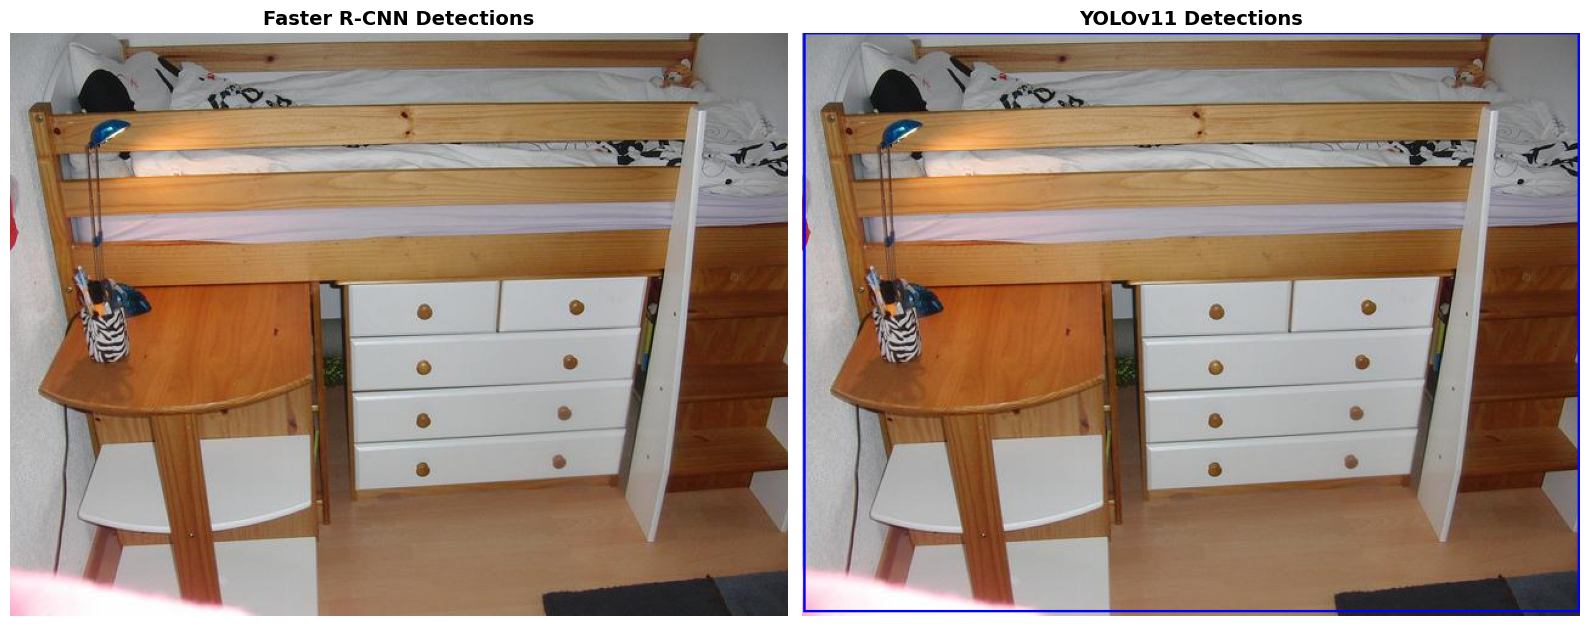


Test Image 3: 000000000532.jpg
  Faster R-CNN detected 7 objects
  YOLOv11 detected 3 objects


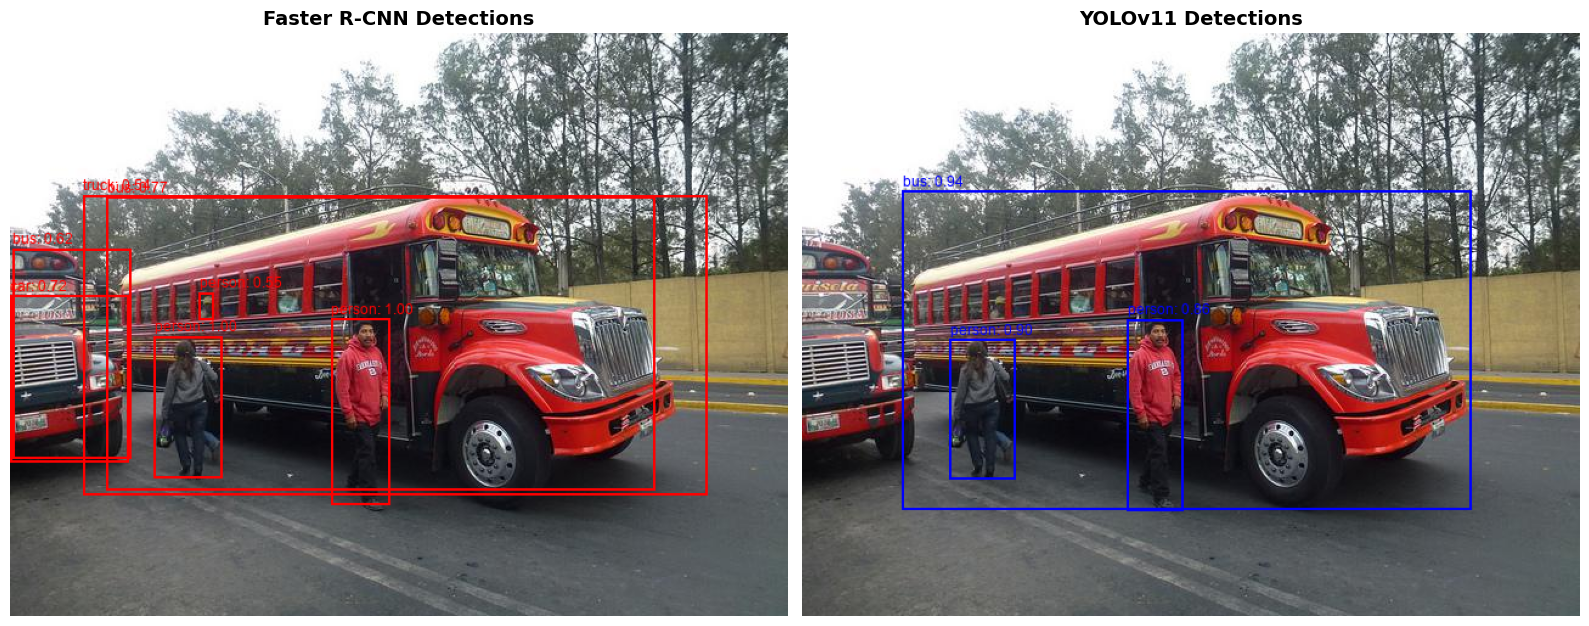


Test Image 5: 000000000074.jpg
  Faster R-CNN detected 4 objects
  YOLOv11 detected 3 objects


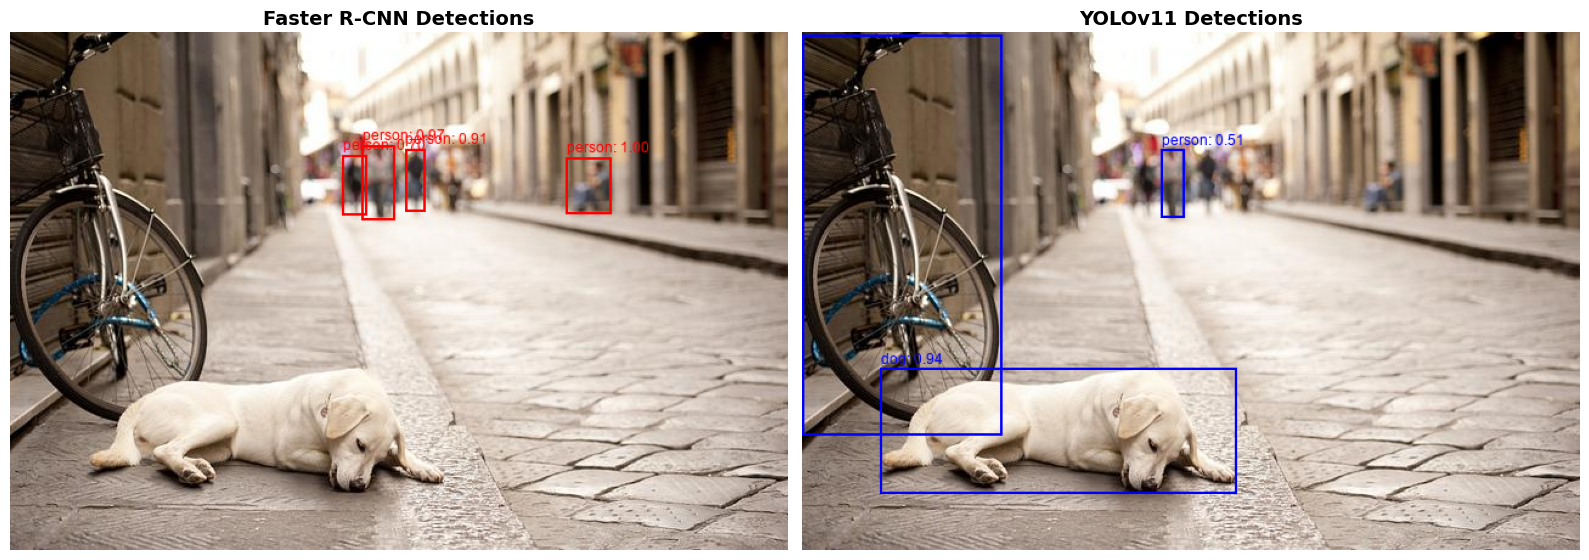


Test Image 7: 000000000394.jpg
  Faster R-CNN detected 2 objects
  YOLOv11 detected 2 objects


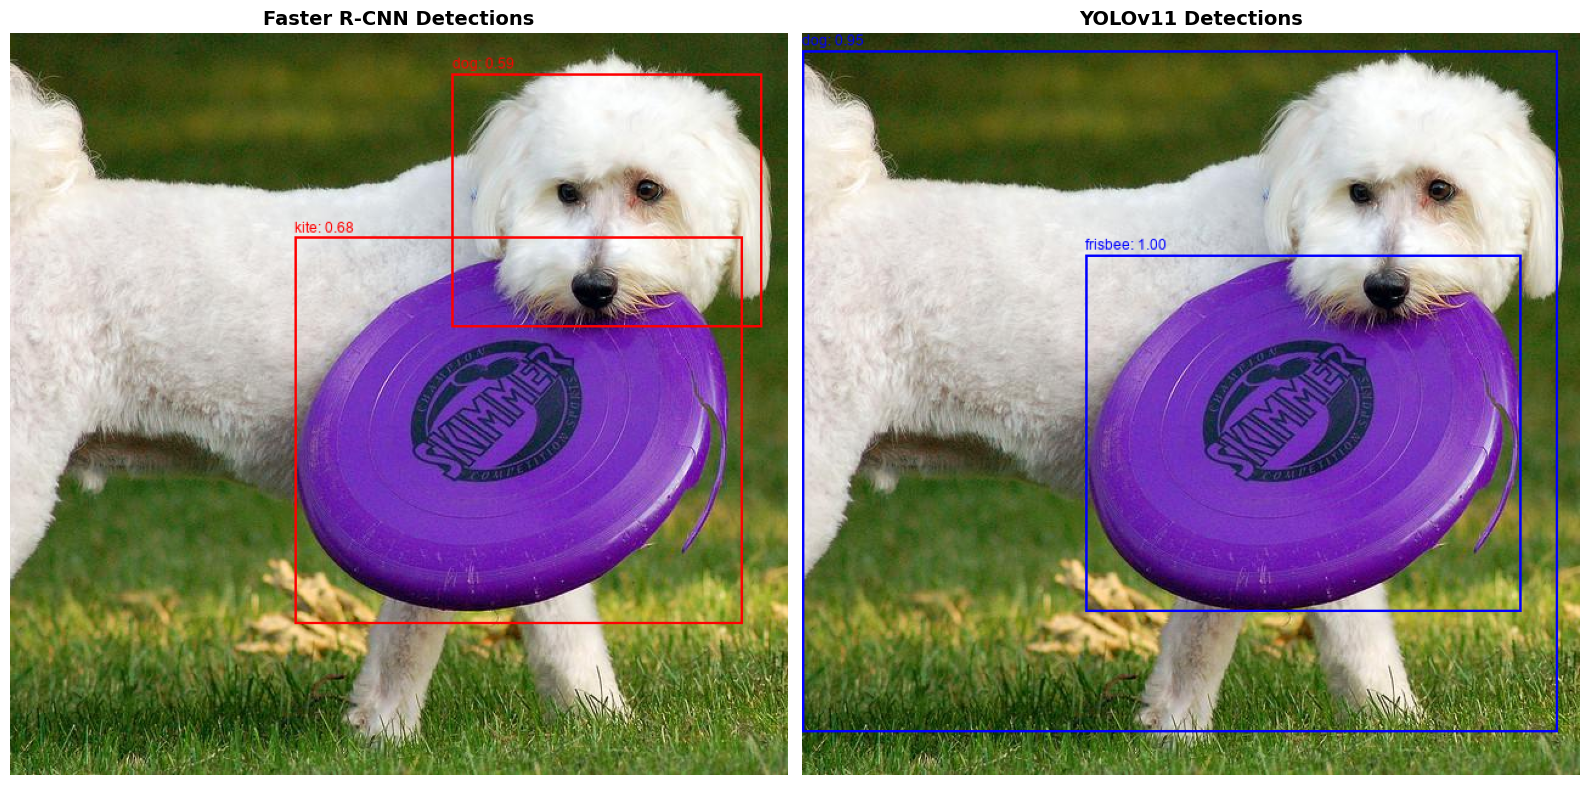


Test Image 9: 000000000564.jpg
  Faster R-CNN detected 3 objects
  YOLOv11 detected 17 objects


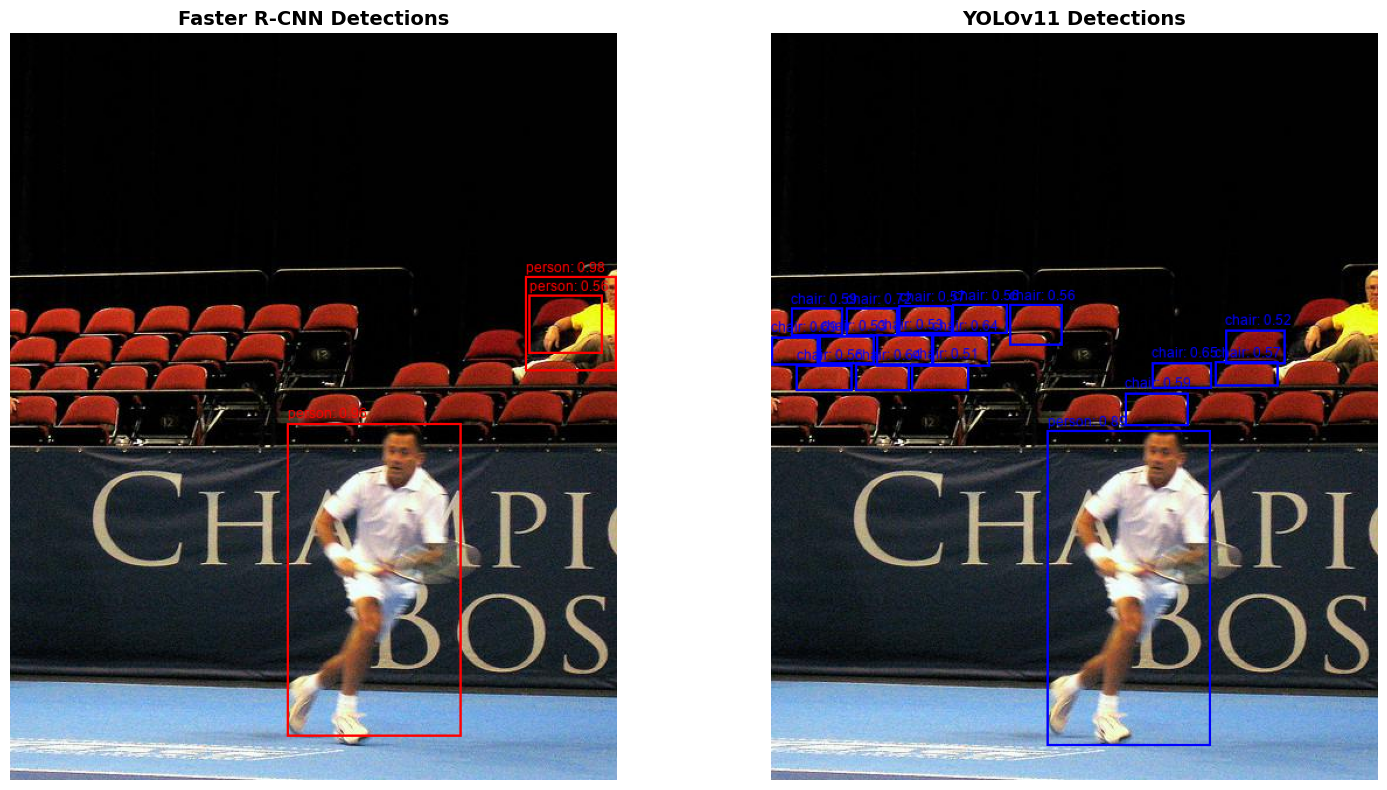


Test Image 11: 000000000443.jpg
  Faster R-CNN detected 2 objects
  YOLOv11 detected 4 objects


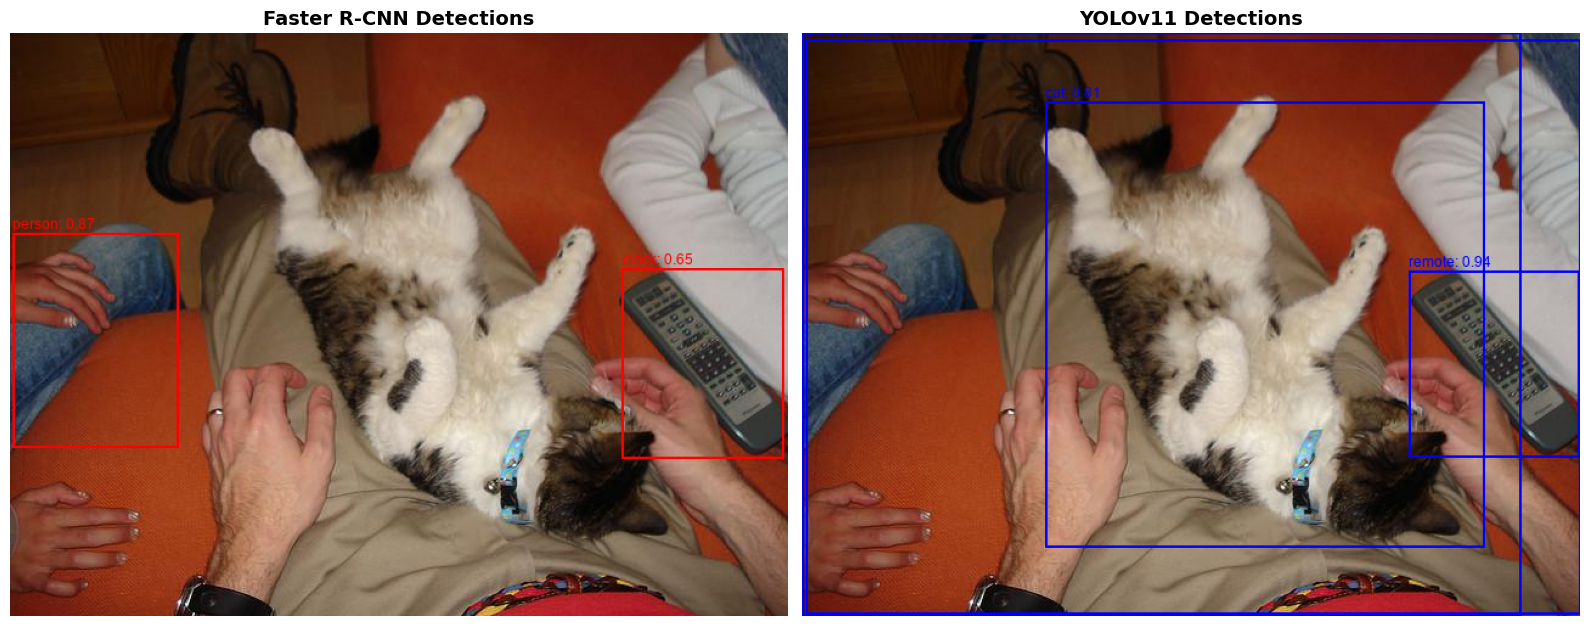


Test Image 13: 000000000194.jpg
  Faster R-CNN detected 1 objects
  YOLOv11 detected 1 objects


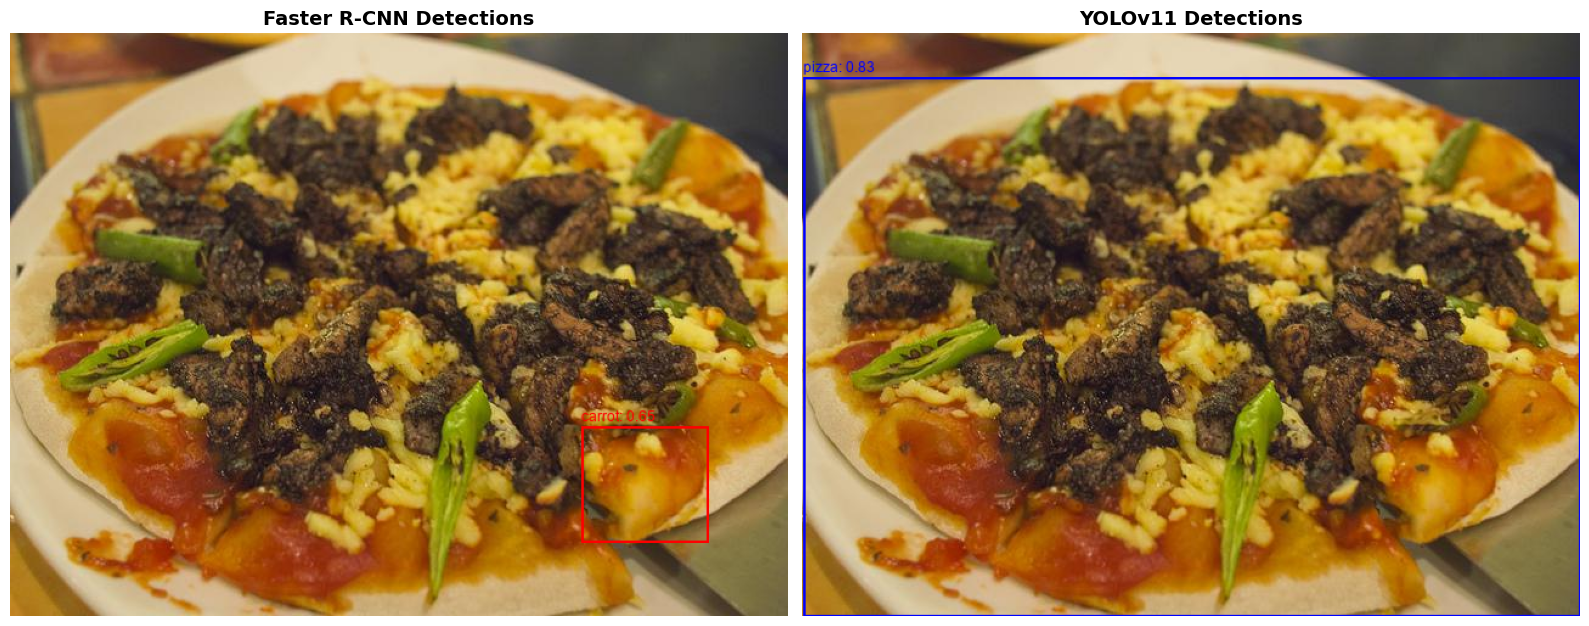


Test Image 15: 000000000471.jpg
  Faster R-CNN detected 2 objects
  YOLOv11 detected 1 objects


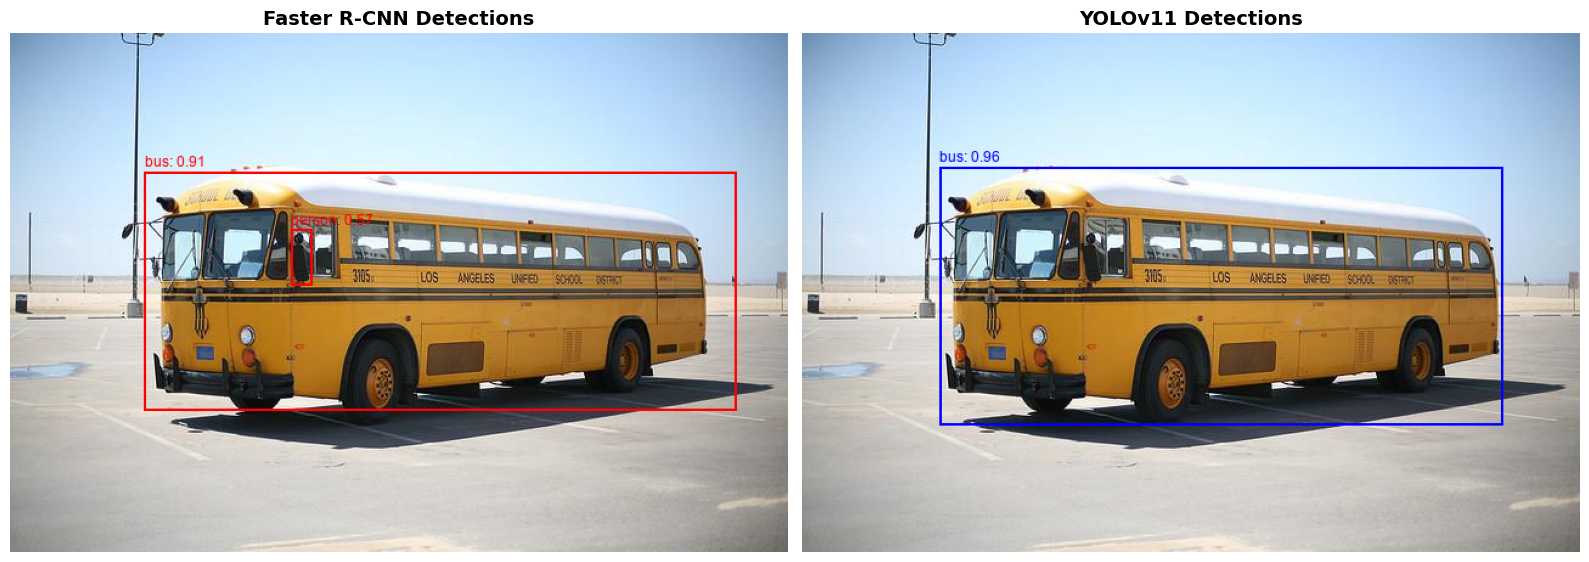

In [29]:
# Visualize detections on sample images FROM TEST SET
print("Visualizing detections on sample images from TEST SET...")
print(f"Note: Using test set ({len(test_dataset)} images) - unseen during training\n")

# Select diverse images from test set
sample_indices = [0, 2, 4, 6, 8, 10, 12, 14] if len(test_dataset) > 14 else range(min(8, len(test_dataset)))
conf_threshold = 0.5

for idx in sample_indices:
    if idx >= len(test_dataset):
        break
    
    sample = test_dataset[idx]
    image_path = sample['image_path']
    
    print(f"\nTest Image {idx + 1}: {os.path.basename(image_path)}")
    
    # Get predictions
    rcnn_boxes, rcnn_labels, rcnn_scores = run_faster_rcnn(faster_rcnn, image_path, conf_threshold)
    yolo_boxes, yolo_labels, yolo_scores = run_yolo(yolo_model, image_path, conf_threshold)
    
    print(f"  Faster R-CNN detected {len(rcnn_boxes)} objects")
    print(f"  YOLOv11 detected {len(yolo_boxes)} objects")
    
    # Visualize
    visualize_detections(image_path, rcnn_boxes, rcnn_labels, rcnn_scores,
                        yolo_boxes, yolo_labels, yolo_scores, conf_threshold)

## Optional: Test reduced input resolutions or lightweight model variants.

In [30]:
# Test with reduced input resolution
print("Testing with reduced input resolutions...")

# Test different image sizes
test_sizes = [320, 416, 640]
size_results = {'size': [], 'rcnn_fps': [], 'yolo_fps': []}

for size in test_sizes:
    print(f"\nTesting with image size: {size}x{size}")
    
    # Prepare resized images
    test_subset = image_files[:20]  # Use smaller subset for speed
    
    # Faster R-CNN with resized images
    start_time = time.time()
    for img_name in test_subset:
        img_path = os.path.join(images_path, img_name)
        image = Image.open(img_path).convert('RGB')
        
        # Resize while maintaining aspect ratio
        image.thumbnail((size, size), Image.Resampling.LANCZOS)
        
        # Save temporarily and run inference
        temp_path = 'temp_resized.jpg'
        image.save(temp_path)
        _ = run_faster_rcnn(faster_rcnn, temp_path, conf_threshold=0.5)
    
    rcnn_time = time.time() - start_time
    rcnn_fps = len(test_subset) / rcnn_time
    
    # YOLOv11 with resized images
    start_time = time.time()
    for img_name in test_subset:
        img_path = os.path.join(images_path, img_name)
        image = Image.open(img_path).convert('RGB')
        image.thumbnail((size, size), Image.Resampling.LANCZOS)
        temp_path = 'temp_resized.jpg'
        image.save(temp_path)
        _ = run_yolo(yolo_model, temp_path, conf_threshold=0.5)
    
    yolo_time = time.time() - start_time
    yolo_fps = len(test_subset) / yolo_time
    
    size_results['size'].append(f'{size}x{size}')
    size_results['rcnn_fps'].append(f'{rcnn_fps:.2f}')
    size_results['yolo_fps'].append(f'{yolo_fps:.2f}')
    
    print(f"  Faster R-CNN: {rcnn_fps:.2f} FPS")
    print(f"  YOLOv11: {yolo_fps:.2f} FPS")

# Clean up temp file
if os.path.exists('temp_resized.jpg'):
    os.remove('temp_resized.jpg')

# Display results table
size_df = pd.DataFrame(size_results)
size_df.columns = ['Input Size', 'Faster R-CNN FPS', 'YOLOv11 FPS']
print("\n" + "="*50)
print("RESOLUTION COMPARISON")
print("="*50)
print(size_df.to_string(index=False))
print("="*50)

Testing with reduced input resolutions...

Testing with image size: 320x320
  Faster R-CNN: 14.79 FPS
  YOLOv11: 35.73 FPS

Testing with image size: 416x416
  Faster R-CNN: 14.36 FPS
  YOLOv11: 38.11 FPS

Testing with image size: 640x640
  Faster R-CNN: 13.88 FPS
  YOLOv11: 33.62 FPS

RESOLUTION COMPARISON
Input Size Faster R-CNN FPS YOLOv11 FPS
   320x320            14.79       35.73
   416x416            14.36       38.11
   640x640            13.88       33.62


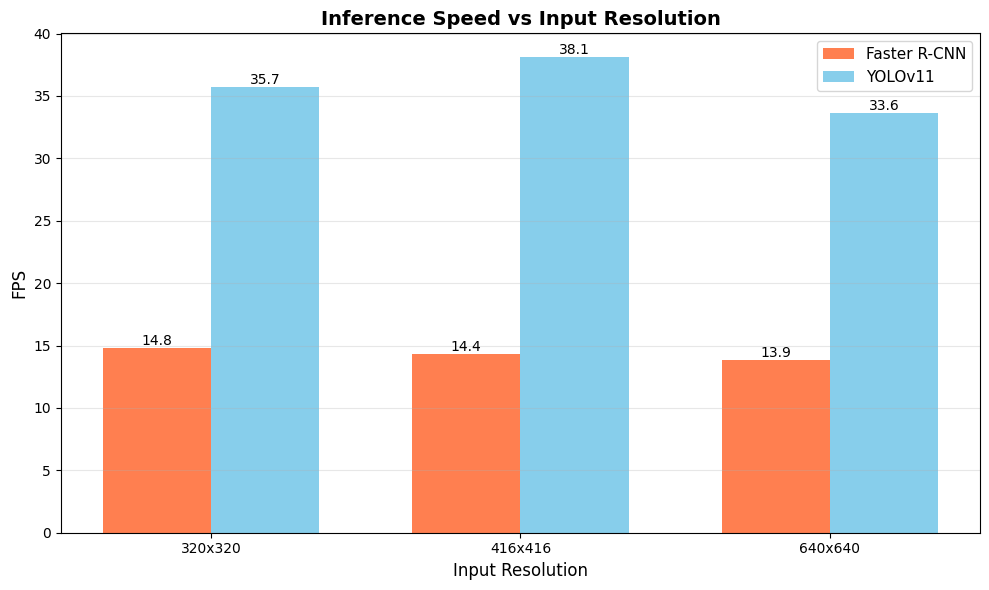

In [31]:
# Plot FPS comparison across different resolutions
fig, ax = plt.subplots(figsize=(10, 6))

sizes = [320, 416, 640]
rcnn_fps_values = [float(size_results['rcnn_fps'][i]) for i in range(len(sizes))]
yolo_fps_values = [float(size_results['yolo_fps'][i]) for i in range(len(sizes))]

x = np.arange(len(sizes))
width = 0.35

bars1 = ax.bar(x - width/2, rcnn_fps_values, width, label='Faster R-CNN', color='coral')
bars2 = ax.bar(x + width/2, yolo_fps_values, width, label='YOLOv11', color='skyblue')

ax.set_xlabel('Input Resolution', fontsize=12)
ax.set_ylabel('FPS', fontsize=12)
ax.set_title('Inference Speed vs Input Resolution', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels([f'{s}x{s}' for s in sizes])
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.1f}',
                ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

In [32]:
# Consolidated tables display: training metrics, quantitative comparison, and resolution comparison
from IPython.display import display, HTML
import pandas as pd
import os

print("\n" + "="*70)
print("ALL TABLES SUMMARY")
print("="*70)

# Helper to show a titled table
def show_table(title, df):
    display(HTML(f"<h3 style='margin:8px 0'>{title}</h3>"))
    try:
        display(df.style.set_properties(**{"text-align": "right"}).set_table_styles([
            {"selector": "th", "props": [("text-align", "left")]},
            {"selector": "table", "props": [("margin", "0 0 16px 0")]}
        ]))
    except Exception:
        display(df)

# 1) YOLOv11 training metrics (last 5 epochs)
yolo_results_path = 'model_task2/yolov11n_coco128_run/results.csv'
if os.path.exists(yolo_results_path):
    yolo_df = pd.read_csv(yolo_results_path)
    # normalize column names
    yolo_df.columns = [c.strip() for c in yolo_df.columns]
    cols = [c for c in ['epoch', 'train/box_loss', 'train/cls_loss', 'train/dfl_loss', 'metrics/mAP50(B)', 'metrics/mAP50-95(B)'] if c in yolo_df.columns]
    show_table('YOLOv11 Training Metrics (last 5 epochs)', yolo_df[cols].tail(5).reset_index(drop=True))
else:
    display(HTML("<p>YOLOv11 results.csv not found.</p>"))

# 2) Faster R-CNN training metrics (last 5 epochs)
rcnn_results_path = 'model_task2/faster_rcnn_training_results.csv'
if os.path.exists(rcnn_results_path):
    rcnn_df = pd.read_csv(rcnn_results_path)
    cols = [c for c in ['epoch', 'train/total_loss', 'train/box_loss', 'train/cls_loss'] if c in rcnn_df.columns]
    show_table('Faster R-CNN Training Metrics (last 5 epochs)', rcnn_df[cols].tail(5).reset_index(drop=True))
else:
    # fallback to variables if present
    if 'training_losses' in globals():
        tmp_df = pd.DataFrame({
            'epoch': list(range(1, len(training_losses)+1)),
            'train/total_loss': training_losses
        })
        show_table('Faster R-CNN Training Losses (in-memory)', tmp_df.tail(5).reset_index(drop=True))
    else:
        display(HTML("<p>Faster R-CNN training metrics not available.</p>"))

# 3) Quantitative comparison table
if 'comparison_df' in globals():
    show_table('Quantitative Comparison (Model Size, mAP, Speed, Memory)', comparison_df)
else:
    # Try reconstruct minimal comparison from available variables
    try:
        comparison_data = {
            'Metric': [
                'Model Type', 'Parameters (M)', 'Model Size (MB)', 'mAP@0.5',
                'Inference Speed (FPS)', 'Avg Time per Image (ms)', 'Peak GPU Memory (MB)'
            ],
            'Faster R-CNN': [
                'Two-Stage', f"{faster_rcnn_size:.2f}", f"{faster_rcnn_file_size:.2f}",
                f"{rcnn_ap:.4f}", f"{rcnn_fps:.2f}", f"{rcnn_time/num_test*1000:.2f}", f"{rcnn_memory:.2f}"
            ],
            'YOLOv11': [
                'Single-Stage', f"{yolo_size:.2f}", f"{yolo_file_size:.2f}",
                f"{yolo_ap:.4f}", f"{yolo_fps:.2f}", f"{yolo_time/num_test*1000:.2f}", f"{yolo_memory:.2f}"
            ]
        }
        comparison_df2 = pd.DataFrame(comparison_data)
        show_table('Quantitative Comparison (Model Size, mAP, Speed, Memory)', comparison_df2)
    except Exception:
        display(HTML("<p>Quantitative comparison variables not available to reconstruct table.</p>"))

# 4) Resolution (input size) vs FPS comparison table
if 'size_df' in globals():
    show_table('Resolution Comparison (Input Size vs FPS)', size_df)
elif 'size_results' in globals() and size_results:
    try:
        size_df2 = pd.DataFrame(size_results)
        size_df2.columns = ['Input Size', 'Faster R-CNN FPS', 'YOLOv11 FPS']
        show_table('Resolution Comparison (Input Size vs FPS)', size_df2)
    except Exception:
        display(HTML("<p>Resolution comparison data structure not valid.</p>"))
else:
    display(HTML("<p>Resolution comparison table not available.</p>"))

print("="*70)
print("End of tables summary")
print("="*70)


ALL TABLES SUMMARY


End of tables summary


## Short discussion on performance trade-offs